# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

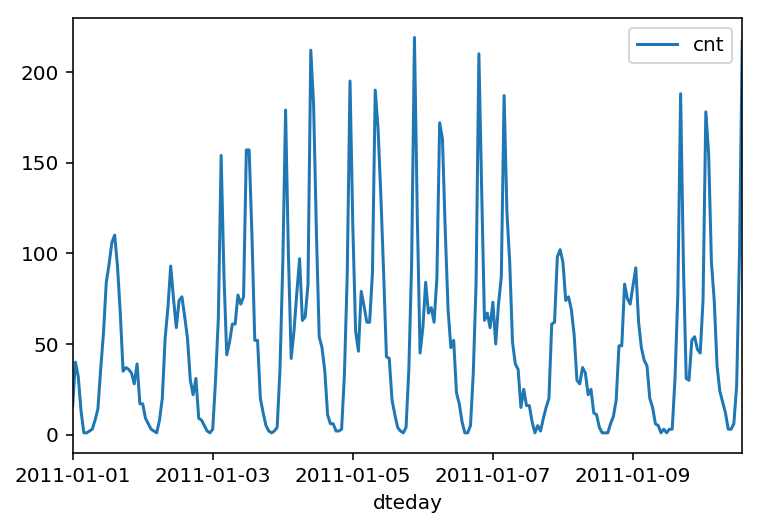

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [457]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        #self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        self.activation_function = lambda x : 1.0 / (1.0 + np.exp(-x))
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
    
      
            
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        
        inputs = np.array(features, ndmin=2)
        target = np.array(targets, ndmin=2)
   
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(inputs, target):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            #hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            print()
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
           # hidden_outputs = (1 / (1 + np.exp(-hidden_inputs)))  # signals from hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)
            print('hidden_outputs = ', hidden_outputs)
            

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs = self.activation_function(final_inputs)  # signals from final output layer
            final_outputs_prime = final_outputs * (1-final_outputs)
            print('final_outputs = ', final_outputs)
            print('final_outputs_prime = ', final_outputs_prime)
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y-final_outputs # Output layer error is the difference between desired target and actual output.
            print('error = ', error)
            
            output_error_term = error*final_outputs*(1-final_outputs) # Error * Derivative of Sigmoid
            print('output_error_term = ', output_error_term)
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = self.weights_hidden_to_output*output_error_term*hidden_outputs
            
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term) # Output error * weightof hidden layer Chain function
            
           # hidden_errors = np.dot(error, 
                               #self.weights_hidden_to_output).T * (self.hidden_outputs * (1 - self.hidden_outputs))
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            #output_error_term = None
            hidden_error_term = hidden_error*hidden_outputs*(1-hidden_outputs)
            
            #hidden_error_term = hidden_error*final_outputs * (1 - final_outputs)
            print('hidden_error = ', hidden_error)
            print('hidden_error_term = ', hidden_error_term)
            
            
            
            # Weight step (input to hidden)
            delta_weights_i_h +=  hidden_error_term * X[:,None] # np.dot(hidden_error_term,X.T)
            # Weight step (hidden to output)
            delta_weights_h_o +=  output_error_term * hidden_outputs[:, None]
            
        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr* delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        inputs = np.array(features, ndmin=2)
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(inputs,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function(final_inputs) # signals from final output layer 
        
        return final_outputs

In [458]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [459]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2], 
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]
                      ])


class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
       # self.assertTrue(np.allclose(network.weights_hidden_to_output, 
        #                            np.array([[ 0.37275328, -0.03172939]])))
 
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([ 0.10562014, -0.20185996],
                                             [0.39775194, 0.50074398],
                                             [-0.29887597, 0.19962801]
                                            )))
                                   # np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                    #          [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))
   

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

...FF


hidden_outputs =  [ 0.4850045   0.45512111]
final_outputs =  [ 0.5249765]
final_outputs_prime =  [ 0.24937617]
error =  [-0.1249765]
output_error_term =  [-0.03116616]
hidden_error =  [-0.00934985  0.00311662]
hidden_error_term =  [-0.00233536  0.00077288]



FAIL: test_run (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-459-22b33b3c25c3>", line 63, in test_run
    self.assertTrue(np.allclose(network.run(inputs), 0.09998924))
AssertionError: False is not true

FAIL: test_train (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-459-22b33b3c25c3>", line 45, in test_train
    [-0.03172939]])))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 5 tests in 0.020s

FAILED (failures=2)


<unittest.runner.TextTestResult run=5 errors=0 failures=2>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [433]:
import sys

### Set the hyperparameters here ###
iterations = 100
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)


hidden_outputs =  [ 0.59948238  0.54001259]
final_outputs =  [ 0.48606398]
final_outputs_prime =  [ 0.24980579]
error =  [-1.29903625]
output_error_term =  [-0.32450677]
hidden_error_term =  [ 0.00713006  0.00013427]

hidden_outputs =  [ 0.56868675  0.34886121]
final_outputs =  [ 0.48684754]
final_outputs_prime =  [ 0.24982701]
error =  [-1.3384112]
output_error_term =  [-0.33437127]
hidden_error_term =  [ 0.00750527  0.00012652]

hidden_outputs =  [ 0.54013866  0.34303366]
final_outputs =  [ 0.48750265]
final_outputs_prime =  [ 0.24984382]
error =  [-0.38530761]
output_error_term =  [-0.09626672]
hidden_error_term =  [  2.18816299e-03   3.61382511e-05]

hidden_outputs =  [ 0.49239652  0.6963131 ]
final_outputs =  [ 0.48844721]
final_outputs_prime =  [ 0.24986653]
error =  [-0.44689579]
output_error_term =  [-0.1116643]
hidden_error_term =  [  2.55402551e-03   3.93329083e-05]

hidden_outputs =  [ 0.56488973  0.60266527]
final_outputs =  [ 0.48682873]
final_outputs_prime =  [ 0.2498265

error =  [-0.81347951]
output_error_term =  [-0.20320251]
hidden_error_term =  [  4.38461195e-03   8.32873509e-05]

hidden_outputs =  [ 0.49273146  0.44333215]
final_outputs =  [ 0.48854485]
final_outputs_prime =  [ 0.24986878]
error =  [-1.35113462]
output_error_term =  [-0.33760636]
hidden_error_term =  [ 0.00772201  0.00013879]

hidden_outputs =  [ 0.59616888  0.51787179]
final_outputs =  [ 0.48614894]
final_outputs_prime =  [ 0.24980815]
error =  [-0.47767586]
output_error_term =  [-0.11932732]
hidden_error_term =  [  2.62893766e-03   4.96290281e-05]

hidden_outputs =  [ 0.63524433  0.48509231]
final_outputs =  [ 0.48526936]
final_outputs_prime =  [ 0.24978301]
error =  [-0.53192683]
output_error_term =  [-0.13286628]
hidden_error_term =  [  2.81727310e-03   5.52814772e-05]

hidden_outputs =  [ 0.5942761   0.40581456]
final_outputs =  [ 0.48623884]
final_outputs_prime =  [ 0.24981063]
error =  [-1.25510666]
output_error_term =  [-0.31353899]
hidden_error_term =  [ 0.00691802  0.000

Progress: 0.0% ... Training loss: 1.226 ... Validation loss: 1.333
hidden_outputs =  [ 0.52452041  0.53002482]
final_outputs =  [ 0.48587908]
final_outputs_prime =  [ 0.2498006]
error =  [-1.36500802]
output_error_term =  [-0.34097982]
hidden_error_term =  [ 0.00841883  0.00073266]

hidden_outputs =  [ 0.49514689  0.55405471]
final_outputs =  [ 0.48655373]
final_outputs_prime =  [ 0.2498192]
error =  [ 0.49221721]
output_error_term =  [ 0.12296531]
hidden_error_term =  [-0.00304306 -0.00026207]

hidden_outputs =  [ 0.49282002  0.65843444]
final_outputs =  [ 0.48638635]
final_outputs_prime =  [ 0.24981467]
error =  [-0.45034799]
output_error_term =  [-0.11250353]
hidden_error_term =  [ 0.00278385  0.00021825]

hidden_outputs =  [ 0.47556346  0.63545274]
final_outputs =  [ 0.48686267]
final_outputs_prime =  [ 0.24982741]
error =  [ 1.51182365]
output_error_term =  [ 0.37769499]
hidden_error_term =  [-0.00932549 -0.00075471]

hidden_outputs =  [ 0.53543678  0.43629086]
final_outputs =  [ 

final_outputs_prime =  [ 0.24989705]
error =  [-0.51445896]
output_error_term =  [-0.12856178]
hidden_error_term =  [ 0.00293389  0.00027193]

hidden_outputs =  [ 0.56177958  0.48866878]
final_outputs =  [ 0.48504682]
final_outputs_prime =  [ 0.2497764]
error =  [-1.47994994]
output_error_term =  [-0.36965657]
hidden_error_term =  [ 0.00900919  0.00079674]

hidden_outputs =  [ 0.6183192   0.51080538]
final_outputs =  [ 0.48360117]
final_outputs_prime =  [ 0.24973108]
error =  [-0.37038002]
output_error_term =  [-0.0924954]
hidden_error_term =  [ 0.00216104  0.00019937]

hidden_outputs =  [ 0.42583364  0.47621072]
final_outputs =  [ 0.4884359]
final_outputs_prime =  [ 0.24986627]
error =  [ 0.79355313]
output_error_term =  [ 0.19828216]
hidden_error_term =  [-0.00479944 -0.00042662]

hidden_outputs =  [ 0.65420934  0.40664017]
final_outputs =  [ 0.48293828]
final_outputs_prime =  [ 0.2497089]
error =  [-1.04230996]
output_error_term =  [-0.26027407]
hidden_error_term =  [ 0.00582894  0.

Progress: 1.0% ... Training loss: 1.225 ... Validation loss: 1.332
hidden_outputs =  [ 0.52789781  0.56347471]
final_outputs =  [ 0.48418119]
final_outputs_prime =  [ 0.24974977]
error =  [-0.75136091]
output_error_term =  [-0.18765221]
hidden_error_term =  [ 0.00492386  0.00063211]

hidden_outputs =  [ 0.5502556   0.57016567]
final_outputs =  [ 0.48357043]
final_outputs_prime =  [ 0.24973007]
error =  [-0.87755044]
output_error_term =  [-0.21915073]
hidden_error_term =  [ 0.00571004  0.00073553]

hidden_outputs =  [ 0.58822283  0.56245283]
final_outputs =  [ 0.48259861]
final_outputs_prime =  [ 0.24969719]
error =  [-0.48515164]
output_error_term =  [-0.121141]
hidden_error_term =  [ 0.00308931  0.00040828]

hidden_outputs =  [ 0.50135839  0.39673301]
final_outputs =  [ 0.48544944]
final_outputs_prime =  [ 0.24978828]
error =  [-1.24329115]
output_error_term =  [-0.31055956]
hidden_error_term =  [ 0.00817425  0.00101791]

hidden_outputs =  [ 0.49679504  0.65130547]
final_outputs =  [ 

hidden_error_term =  [ 0.00245355  0.00031389]

hidden_outputs =  [ 0.56662199  0.55284987]
final_outputs =  [ 0.48319935]
final_outputs_prime =  [ 0.24971774]
error =  [-1.46156329]
output_error_term =  [-0.36497828]
hidden_error_term =  [ 0.00943612  0.00123562]

hidden_outputs =  [ 0.56050778  0.59851207]
final_outputs =  [ 0.48320394]
final_outputs_prime =  [ 0.24971789]
error =  [ 2.9929814]
output_error_term =  [ 0.74740101]
hidden_error_term =  [-0.01938442 -0.00245955]

hidden_outputs =  [ 0.51244276  0.63982258]
final_outputs =  [ 0.48432645]
final_outputs_prime =  [ 0.24975434]
error =  [-1.44063817]
output_error_term =  [-0.35980564]
hidden_error_term =  [ 0.00946466  0.00113553]

hidden_outputs =  [ 0.58609092  0.71035055]
final_outputs =  [ 0.48214893]
final_outputs_prime =  [ 0.24968134]
error =  [-0.24764055]
output_error_term =  [-0.06183122]
hidden_error_term =  [ 0.00157922  0.00017422]

hidden_outputs =  [ 0.5167182   0.46869342]
final_outputs =  [ 0.48479936]
final_

Progress: 2.0% ... Training loss: 1.223 ... Validation loss: 1.332
hidden_outputs =  [ 0.55642834  0.36521405]
final_outputs =  [ 0.48250223]
final_outputs_prime =  [ 0.24969383]
error =  [-0.84891695]
output_error_term =  [-0.21196932]
hidden_error_term =  [ 0.00588631  0.00099773]

hidden_outputs =  [ 0.5218951   0.54733573]
final_outputs =  [ 0.4825491]
final_outputs_prime =  [ 0.24969547]
error =  [-1.51053055]
output_error_term =  [-0.37717263]
hidden_error_term =  [ 0.01058873  0.0018973 ]

hidden_outputs =  [ 0.5253665   0.47180844]
final_outputs =  [ 0.48283448]
final_outputs_prime =  [ 0.24970534]
error =  [ 0.99211152]
output_error_term =  [ 0.24773555]
hidden_error_term =  [-0.00695035 -0.00125346]

hidden_outputs =  [ 0.48116168  0.45719791]
final_outputs =  [ 0.48415059]
final_outputs_prime =  [ 0.2497488]
error =  [-1.07108756]
output_error_term =  [-0.26750283]
hidden_error_term =  [ 0.00751361  0.00134784]

hidden_outputs =  [ 0.54011006  0.47841659]
final_outputs =  [ 

hidden_outputs =  [ 0.60647673  0.44084879]
final_outputs =  [ 0.48071299]
final_outputs_prime =  [ 0.24962801]
error =  [-1.45907694]
output_error_term =  [-0.36422647]
hidden_error_term =  [ 0.00978033  0.00182287]

hidden_outputs =  [ 0.32491396  0.71079936]
final_outputs =  [ 0.48725573]
final_outputs_prime =  [ 0.24983758]
error =  [-0.50083487]
output_error_term =  [-0.12512737]
hidden_error_term =  [ 0.003088    0.00052223]

hidden_outputs =  [ 0.66049718  0.60278374]
final_outputs =  [ 0.47837548]
final_outputs_prime =  [ 0.24953238]
error =  [-1.20313885]
output_error_term =  [-0.3002221]
hidden_error_term =  [ 0.00757451  0.00145948]

hidden_outputs =  [ 0.55682968  0.44897065]
final_outputs =  [ 0.48206635]
final_outputs_prime =  [ 0.24967838]
error =  [-0.46256716]
output_error_term =  [-0.11549302]
hidden_error_term =  [ 0.00320661  0.00058012]

hidden_outputs =  [ 0.57047815  0.46592304]
final_outputs =  [ 0.48159702]
final_outputs_prime =  [ 0.24966133]
error =  [-1.3717

Progress: 3.0% ... Training loss: 1.221 ... Validation loss: 1.331
hidden_outputs =  [ 0.33920474  0.58789962]
final_outputs =  [ 0.48599678]
final_outputs_prime =  [ 0.24980391]
error =  [ 0.54790473]
output_error_term =  [ 0.13686874]
hidden_error_term =  [-0.00367382 -0.000869  ]

hidden_outputs =  [ 0.62280152  0.60938258]
final_outputs =  [ 0.47737746]
final_outputs_prime =  [ 0.24948822]
error =  [ 1.70875276]
output_error_term =  [ 0.42631369]
hidden_error_term =  [-0.01199317 -0.00265939]

hidden_outputs =  [ 0.63302817  0.55475458]
final_outputs =  [ 0.47742909]
final_outputs_prime =  [ 0.24949055]
error =  [-1.37861025]
output_error_term =  [-0.34395024]
hidden_error_term =  [ 0.00956834  0.00222642]

hidden_outputs =  [ 0.4637414   0.64333768]
final_outputs =  [ 0.48190941]
final_outputs_prime =  [ 0.24967273]
error =  [ 0.03376483]
output_error_term =  [ 0.00843016]
hidden_error_term =  [ -2.51056199e-04  -5.06924096e-05]

hidden_outputs =  [ 0.46496452  0.63437326]
final_o

output_error_term =  [-0.06901125]
hidden_error_term =  [ 0.00201638  0.0004261 ]

hidden_outputs =  [ 0.40613531  0.59504851]
final_outputs =  [ 0.48394802]
final_outputs_prime =  [ 0.24974233]
error =  [ 1.17844188]
output_error_term =  [ 0.29430682]
hidden_error_term =  [-0.00850048 -0.00185852]

hidden_outputs =  [ 0.64495093  0.49405338]
final_outputs =  [ 0.47746976]
final_outputs_prime =  [ 0.24949239]
error =  [ 0.17603089]
output_error_term =  [ 0.04391837]
hidden_error_term =  [-0.00120433 -0.0002877 ]

hidden_outputs =  [ 0.66561494  0.43535867]
final_outputs =  [ 0.47723614]
final_outputs_prime =  [ 0.24948181]
error =  [-1.49970454]
output_error_term =  [-0.374149]
hidden_error_term =  [ 0.0099724   0.00241032]

hidden_outputs =  [ 0.47131003  0.54628868]
final_outputs =  [ 0.48231813]
final_outputs_prime =  [ 0.24968735]
error =  [ 0.18220863]
output_error_term =  [ 0.04549519]
hidden_error_term =  [-0.00135756 -0.00029551]

hidden_outputs =  [ 0.46829591  0.5542878 ]
fin

Progress: 4.0% ... Training loss: 1.219 ... Validation loss: 1.330
hidden_outputs =  [ 0.43973725  0.45403627]
final_outputs =  [ 0.48236758]
final_outputs_prime =  [ 0.2496891]
error =  [-0.74403425]
output_error_term =  [-0.18577724]
hidden_error_term =  [ 0.00580474  0.00150004]

hidden_outputs =  [ 0.49045763  0.57970626]
final_outputs =  [ 0.47973986]
final_outputs_prime =  [ 0.24958953]
error =  [-1.47464297]
output_error_term =  [-0.36805544]
hidden_error_term =  [ 0.01166541  0.00292099]

hidden_outputs =  [ 0.66434424  0.41934509]
final_outputs =  [ 0.47554086]
final_outputs_prime =  [ 0.24940175]
error =  [-1.47595703]
output_error_term =  [-0.36810627]
hidden_error_term =  [ 0.01041035  0.00291957]

hidden_outputs =  [ 0.47709207  0.56936906]
final_outputs =  [ 0.48024699]
final_outputs_prime =  [ 0.24960982]
error =  [ 0.4544195]
output_error_term =  [ 0.11342757]
hidden_error_term =  [-0.00358881 -0.00090589]

hidden_outputs =  [ 0.44946114  0.59624003]
final_outputs =  [ 

hidden_error_term =  [-0.01109514 -0.00277273]

hidden_outputs =  [ 0.53562758  0.4276662 ]
final_outputs =  [ 0.4795461]
final_outputs_prime =  [ 0.24958164]
error =  [-1.51855367]
output_error_term =  [-0.37900311]
hidden_error_term =  [ 0.01195576  0.00302171]

hidden_outputs =  [ 0.48182206  0.38364285]
final_outputs =  [ 0.48160745]
final_outputs_prime =  [ 0.24966171]
error =  [ 0.71217269]
output_error_term =  [ 0.17780225]
hidden_error_term =  [-0.00562999 -0.00136947]

hidden_outputs =  [ 0.53036355  0.60679675]
final_outputs =  [ 0.47825661]
final_outputs_prime =  [ 0.24952723]
error =  [-0.93288023]
output_error_term =  [-0.23277902]
hidden_error_term =  [ 0.00735333  0.00180909]

hidden_outputs =  [ 0.53424875  0.4671405 ]
final_outputs =  [ 0.47926885]
final_outputs_prime =  [ 0.24957022]
error =  [-0.79606607]
output_error_term =  [-0.19867438]
hidden_error_term =  [ 0.00626966  0.00161086]

hidden_outputs =  [ 0.35900988  0.41823775]
final_outputs =  [ 0.48521566]
final_


hidden_outputs =  [ 0.50313983  0.54331252]
final_outputs =  [ 0.47963429]
final_outputs_prime =  [ 0.24958524]
error =  [-0.79091846]
output_error_term =  [-0.19740157]
hidden_error_term =  [ 0.00625862  0.00159542]

hidden_outputs =  [ 0.65933266  0.45422456]
final_outputs =  [ 0.47541603]
final_outputs_prime =  [ 0.24939563]
error =  [-1.49788442]
output_error_term =  [-0.37356583]
hidden_error_term =  [ 0.01064161  0.00301653]

hidden_outputs =  [ 0.62053025  0.55537837]
final_outputs =  [ 0.47582162]
final_outputs_prime =  [ 0.24941541]
error =  [-1.29430695]
output_error_term =  [-0.32282009]
hidden_error_term =  [ 0.00964063  0.00259654]

hidden_outputs =  [ 0.59025007  0.46430051]
final_outputs =  [ 0.47751965]
final_outputs_prime =  [ 0.24949463]
error =  [-0.45802046]
output_error_term =  [-0.11427365]
hidden_error_term =  [ 0.00350514  0.00092581]

hidden_outputs =  [ 0.46196627  0.51216009]
final_outputs =  [ 0.48119104]
final_outputs_prime =  [ 0.24964622]
error =  [-1.02

hidden_error_term =  [ 0.00469885  0.0013814 ]

hidden_outputs =  [ 0.42975227  0.48476444]
final_outputs =  [ 0.48119541]
final_outputs_prime =  [ 0.24964639]
error =  [-0.6767054]
output_error_term =  [-0.16893706]
hidden_error_term =  [ 0.00550583  0.0015756 ]

hidden_outputs =  [ 0.45343035  0.37830441]
final_outputs =  [ 0.48140172]
final_outputs_prime =  [ 0.2496541]
error =  [-0.97461673]
output_error_term =  [-0.24331707]
hidden_error_term =  [ 0.00801945  0.00213686]

hidden_outputs =  [ 0.39621983  0.57397706]
final_outputs =  [ 0.48147706]
final_outputs_prime =  [ 0.2496569]
error =  [-0.88097012]
output_error_term =  [-0.21994027]
hidden_error_term =  [ 0.00699738  0.00200824]

hidden_outputs =  [ 0.579942    0.56880859]
final_outputs =  [ 0.47542838]
final_outputs_prime =  [ 0.24939624]
error =  [ 0.13396781]
output_error_term =  [ 0.03341107]
hidden_error_term =  [-0.00108243 -0.00030599]

hidden_outputs =  [ 0.51384339  0.4332138 ]
final_outputs =  [ 0.47888454]
final_ou

hidden_outputs =  [ 0.46383377  0.55245259]
final_outputs =  [ 0.47791762]
final_outputs_prime =  [ 0.24951237]
error =  [-0.46944453]
output_error_term =  [-0.11713222]
hidden_error_term =  [ 0.00406232  0.00124256]

hidden_outputs =  [ 0.47647489  0.61027159]
final_outputs =  [ 0.47685889]
final_outputs_prime =  [ 0.24946449]
error =  [-0.30299413]
output_error_term =  [-0.07558627]
hidden_error_term =  [ 0.0026294   0.00077132]

hidden_outputs =  [ 0.62452433  0.57390397]
final_outputs =  [ 0.47209987]
final_outputs_prime =  [ 0.24922158]
error =  [ 0.10421799]
output_error_term =  [ 0.02597337]
hidden_error_term =  [-0.00084937 -0.00027251]

hidden_outputs =  [ 0.49486661  0.50021289]
final_outputs =  [ 0.47739707]
final_outputs_prime =  [ 0.24948911]
error =  [-1.2076735]
output_error_term =  [-0.30130138]
hidden_error_term =  [ 0.01050342  0.00323182]

hidden_outputs =  [ 0.50745513  0.60593522]
final_outputs =  [ 0.47582763]
final_outputs_prime =  [ 0.2494157]
error =  [-0.27439

final_outputs_prime =  [ 0.24953363]
error =  [-0.06196515]
output_error_term =  [-0.01546239]
hidden_error_term =  [ 0.0005388   0.00016226]

hidden_outputs =  [ 0.63045696  0.60617798]
final_outputs =  [ 0.47154861]
final_outputs_prime =  [ 0.24919052]
error =  [-0.95373752]
output_error_term =  [-0.23766235]
hidden_error_term =  [ 0.00772176  0.00243426]

hidden_outputs =  [ 0.57706461  0.46641884]
final_outputs =  [ 0.47489951]
final_outputs_prime =  [ 0.24936997]
error =  [ 0.79606341]
output_error_term =  [ 0.1985143]
hidden_error_term =  [-0.00675656 -0.0021197 ]

hidden_outputs =  [ 0.58144607  0.54007499]
final_outputs =  [ 0.47395917]
final_outputs_prime =  [ 0.24932188]
error =  [-0.39381636]
output_error_term =  [-0.09818703]
hidden_error_term =  [ 0.00333235  0.00104641]

hidden_outputs =  [ 0.47324823  0.39394893]
final_outputs =  [ 0.47928702]
final_outputs_prime =  [ 0.24957097]
error =  [-1.41905958]
output_error_term =  [-0.35415608]
hidden_error_term =  [ 0.0123119  

final_outputs =  [ 0.47697731]
final_outputs_prime =  [ 0.24946996]
error =  [-1.2623843]
output_error_term =  [-0.31492695]
hidden_error_term =  [ 0.01142183  0.00393112]

hidden_outputs =  [ 0.56879287  0.46285515]
final_outputs =  [ 0.47305803]
final_outputs_prime =  [ 0.24927413]
error =  [-0.9221686]
output_error_term =  [-0.22987278]
hidden_error_term =  [ 0.00835874  0.00290725]

hidden_outputs =  [ 0.54547353  0.57348725]
final_outputs =  [ 0.472517]
final_outputs_prime =  [ 0.24924468]
error =  [ 0.26367949]
output_error_term =  [ 0.06572071]
hidden_error_term =  [-0.00241573 -0.00081774]

hidden_outputs =  [ 0.50905006  0.49301234]
final_outputs =  [ 0.47488386]
final_outputs_prime =  [ 0.24936918]
error =  [-1.39811725]
output_error_term =  [-0.34864735]
hidden_error_term =  [ 0.01291806  0.00443302]

hidden_outputs =  [ 0.61211948  0.58404429]
final_outputs =  [ 0.4699212]
final_outputs_prime =  [ 0.24909527]
error =  [-0.26849116]
output_error_term =  [-0.06687988]
hidden_

hidden_error_term =  [  1.87427350e-04   6.11567742e-05]

hidden_outputs =  [ 0.61113833  0.47703395]
final_outputs =  [ 0.47131363]
final_outputs_prime =  [ 0.24917709]
error =  [-0.83772836]
output_error_term =  [-0.20874272]
hidden_error_term =  [ 0.0073546   0.00264906]

hidden_outputs =  [ 0.59383216  0.62022018]
final_outputs =  [ 0.47013816]
final_outputs_prime =  [ 0.24910827]
error =  [-0.58846537]
output_error_term =  [-0.14659159]
hidden_error_term =  [ 0.00524193  0.00175649]

hidden_outputs =  [ 0.47936353  0.56796802]
final_outputs =  [ 0.47503055]
final_outputs_prime =  [ 0.24937653]
error =  [-0.85247139]
output_error_term =  [-0.21258635]
hidden_error_term =  [ 0.0078659   0.00265358]

hidden_outputs =  [ 0.49504991  0.53682976]
final_outputs =  [ 0.47484561]
final_outputs_prime =  [ 0.24936726]
error =  [ 0.43776866]
output_error_term =  [ 0.10916517]
hidden_error_term =  [-0.00404571 -0.00138076]

hidden_outputs =  [ 0.39784396  0.4339414 ]
final_outputs =  [ 0.47974

final_outputs =  [ 0.47274451]
final_outputs_prime =  [ 0.24925714]
error =  [-1.37943873]
output_error_term =  [-0.34383495]
hidden_error_term =  [ 0.01304982  0.00464546]

hidden_outputs =  [ 0.56636243  0.45543256]
final_outputs =  [ 0.47221248]
final_outputs_prime =  [ 0.24922785]
error =  [-0.86067944]
output_error_term =  [-0.21450529]
hidden_error_term =  [ 0.00805724  0.00287873]

hidden_outputs =  [ 0.63313681  0.79348221]
final_outputs =  [ 0.46511437]
final_outputs_prime =  [ 0.24878299]
error =  [ 0.87200522]
output_error_term =  [ 0.21694007]
hidden_error_term =  [-0.0077067  -0.00192363]

hidden_outputs =  [ 0.4528712   0.63331254]
final_outputs =  [ 0.47413999]
final_outputs_prime =  [ 0.24933126]
error =  [ 0.63143125]
output_error_term =  [ 0.15743555]
hidden_error_term =  [-0.00596615 -0.00197836]

hidden_outputs =  [ 0.45690309  0.62949898]
final_outputs =  [ 0.47403769]
final_outputs_prime =  [ 0.24932596]
error =  [-1.51304526]
output_error_term =  [-0.37724146]
hi

hidden_outputs =  [ 0.52832361  0.4445931 ]
final_outputs =  [ 0.47380889]
final_outputs_prime =  [ 0.24931403]
error =  [-0.58662304]
output_error_term =  [-0.14625335]
hidden_error_term =  [ 0.00557413  0.00195419]

hidden_outputs =  [ 0.52975141  0.52913371]
final_outputs =  [ 0.47261408]
final_outputs_prime =  [ 0.24925001]
error =  [-0.64055879]
output_error_term =  [-0.15965929]
hidden_error_term =  [ 0.00608304  0.00215251]

hidden_outputs =  [ 0.65023827  0.55102384]
final_outputs =  [ 0.46772857]
final_outputs_prime =  [ 0.24895855]
error =  [-0.81760413]
output_error_term =  [-0.20354954]
hidden_error_term =  [ 0.00708014  0.00272491]

hidden_outputs =  [ 0.44540852  0.5604706 ]
final_outputs =  [ 0.47540749]
final_outputs_prime =  [ 0.24939521]
error =  [-0.00935075]
output_error_term =  [-0.00233203]
hidden_error_term =  [  8.81035453e-05   3.10858640e-05]

hidden_outputs =  [ 0.36526523  0.4818049 ]
final_outputs =  [ 0.47952757]
final_outputs_prime =  [ 0.24958088]
error 

error =  [-0.501157]
output_error_term =  [-0.1250137]
hidden_error_term =  [ 0.00424432  0.00151646]

hidden_outputs =  [ 0.62812045  0.40332255]
final_outputs =  [ 0.46836475]
final_outputs_prime =  [ 0.24899921]
error =  [-1.26479785]
output_error_term =  [-0.31493367]
hidden_error_term =  [ 0.01191272  0.00469676]

hidden_outputs =  [ 0.55521546  0.6167831 ]
final_outputs =  [ 0.46801061]
final_outputs_prime =  [ 0.24897668]
error =  [-0.72416422]
output_error_term =  [-0.1803]
hidden_error_term =  [ 0.0072103   0.00264095]

hidden_outputs =  [ 0.4835418   0.44603434]
final_outputs =  [ 0.47353862]
final_outputs_prime =  [ 0.2492998]
error =  [ 1.76772216]
output_error_term =  [ 0.44069277]
hidden_error_term =  [-0.0178218  -0.00674799]

hidden_outputs =  [ 0.47281432  0.57336148]
final_outputs =  [ 0.47200484]
final_outputs_prime =  [ 0.24921627]
error =  [ 0.06020857]
output_error_term =  [ 0.01500496]
hidden_error_term =  [-0.00060567 -0.00022746]

hidden_outputs =  [ 0.58368774

output_error_term =  [-0.04900372]
hidden_error_term =  [ 0.00198013  0.0007366 ]

hidden_outputs =  [ 0.44206323  0.74513769]
final_outputs =  [ 0.47059316]
final_outputs_prime =  [ 0.24913524]
error =  [ 1.78169373]
output_error_term =  [ 0.44388269]
hidden_error_term =  [-0.01772899 -0.00522393]

hidden_outputs =  [ 0.53598941  0.35095807]
final_outputs =  [ 0.47289017]
final_outputs_prime =  [ 0.24926506]
error =  [-0.74558295]
output_error_term =  [-0.18584778]
hidden_error_term =  [ 0.00748493  0.00262345]

hidden_outputs =  [ 0.48190333  0.5588203 ]
final_outputs =  [ 0.47186261]
final_outputs_prime =  [ 0.24920829]
error =  [-0.45787647]
output_error_term =  [-0.11410661]
hidden_error_term =  [ 0.00461347  0.00174335]

hidden_outputs =  [ 0.48776838  0.59741901]
final_outputs =  [ 0.47102989]
final_outputs_prime =  [ 0.24916073]
error =  [-0.76026183]
output_error_term =  [-0.1894274]
hidden_error_term =  [ 0.00766424  0.00282333]

hidden_outputs =  [ 0.42922576  0.54593749]
fi

Progress: 10.0% ... Training loss: 1.210 ... Validation loss: 1.327
hidden_outputs =  [ 0.5690325   0.53863083]
final_outputs =  [ 0.46763195]
final_outputs_prime =  [ 0.24895231]
error =  [-0.0291405]
output_error_term =  [-0.00725459]
hidden_error_term =  [ 0.00029521  0.00011792]

hidden_outputs =  [ 0.53012592  0.60770649]
final_outputs =  [ 0.46811437]
final_outputs_prime =  [ 0.24898331]
error =  [-1.12120802]
output_error_term =  [-0.27916208]
hidden_error_term =  [ 0.01153856  0.00435317]

hidden_outputs =  [ 0.65145933  0.66719511]
final_outputs =  [ 0.46213755]
final_outputs_prime =  [ 0.24856644]
error =  [ 0.17482392]
output_error_term =  [ 0.04345536]
hidden_error_term =  [-0.00163726 -0.00063115]

hidden_outputs =  [ 0.66105041  0.58056247]
final_outputs =  [ 0.46315065]
final_outputs_prime =  [ 0.24864213]
error =  [ 0.45497668]
output_error_term =  [ 0.11312637]
hidden_error_term =  [-0.00420599 -0.00180187]

hidden_outputs =  [ 0.52356611  0.55152636]
final_outputs =  

Progress: 11.0% ... Training loss: 1.210 ... Validation loss: 1.327
hidden_outputs =  [ 0.57412786  0.5093176 ]
final_outputs =  [ 0.46728952]
final_outputs_prime =  [ 0.24893002]
error =  [-1.02114816]
output_error_term =  [-0.25419444]
hidden_error_term =  [ 0.01049984  0.00424536]

hidden_outputs =  [ 0.47191945  0.39283871]
final_outputs =  [ 0.47353026]
final_outputs_prime =  [ 0.24929935]
error =  [ 0.16894427]
output_error_term =  [ 0.0421177]
hidden_error_term =  [-0.00177321 -0.00067134]

hidden_outputs =  [ 0.66977061  0.61479043]
final_outputs =  [ 0.46151742]
final_outputs_prime =  [ 0.24851909]
error =  [ 1.70256058]
output_error_term =  [ 0.42311881]
hidden_error_term =  [-0.01581003 -0.00669647]

hidden_outputs =  [ 0.60245531  0.67460505]
final_outputs =  [ 0.46335072]
final_outputs_prime =  [ 0.24865683]
error =  [ 0.61465523]
output_error_term =  [ 0.15283822]
hidden_error_term =  [-0.00618403 -0.00224208]

hidden_outputs =  [ 0.42272951  0.59975399]
final_outputs =  

error =  [-0.48929712]
output_error_term =  [-0.12171429]
hidden_error_term =  [ 0.00474002  0.00203348]

hidden_outputs =  [ 0.51999527  0.74140492]
final_outputs =  [ 0.46570545]
final_outputs_prime =  [ 0.24882388]
error =  [ 1.49990253]
output_error_term =  [ 0.37321157]
hidden_error_term =  [-0.01573724 -0.00478179]

hidden_outputs =  [ 0.58722449  0.54179755]
final_outputs =  [ 0.4661986]
final_outputs_prime =  [ 0.24885747]
error =  [-1.46661477]
output_error_term =  [-0.36497803]
hidden_error_term =  [ 0.0149456   0.00605509]

hidden_outputs =  [ 0.55107067  0.45388009]
final_outputs =  [ 0.46918186]
final_outputs_prime =  [ 0.24905024]
error =  [-0.88521409]
output_error_term =  [-0.22046278]
hidden_error_term =  [ 0.00921402  0.00365194]

hidden_outputs =  [ 0.43354107  0.58293313]
final_outputs =  [ 0.47197986]
final_outputs_prime =  [ 0.24921487]
error =  [-1.29597824]
output_error_term =  [-0.32297705]
hidden_error_term =  [ 0.01339982  0.00524754]

hidden_outputs =  [ 0.6

hidden_error_term =  [ 0.0012415   0.00042328]

hidden_outputs =  [ 0.48154949  0.29291587]
final_outputs =  [ 0.47379125]
final_outputs_prime =  [ 0.2493131]
error =  [-0.94495404]
output_error_term =  [-0.23558942]
hidden_error_term =  [ 0.01027279  0.00346914]

hidden_outputs =  [ 0.51135651  0.63949894]
final_outputs =  [ 0.46635636]
final_outputs_prime =  [ 0.24886811]
error =  [ 0.55100598]
output_error_term =  [ 0.13712781]
hidden_error_term =  [-0.00598447 -0.00224762]

hidden_outputs =  [ 0.59220592  0.5485818 ]
final_outputs =  [ 0.46445129]
final_outputs_prime =  [ 0.24873629]
error =  [-0.29058653]
output_error_term =  [-0.07227942]
hidden_error_term =  [ 0.00304869  0.00127259]

hidden_outputs =  [ 0.62268543  0.55616361]
final_outputs =  [ 0.46299339]
final_outputs_prime =  [ 0.24863051]
error =  [-1.07749564]
output_error_term =  [-0.26789829]
hidden_error_term =  [ 0.01099327  0.00470162]

hidden_outputs =  [ 0.56582907  0.49729975]
final_outputs =  [ 0.46650468]
final_

error =  [-1.33218748]
output_error_term =  [-0.33076042]
hidden_error_term =  [ 0.0124999   0.00633963]

hidden_outputs =  [ 0.47512842  0.68276463]
final_outputs =  [ 0.46541387]
final_outputs_prime =  [ 0.2488038]
error =  [-0.2419316]
output_error_term =  [-0.0601935]
hidden_error_term =  [ 0.00272402  0.00099957]

hidden_outputs =  [ 0.55734264  0.59762619]
final_outputs =  [ 0.46332658]
final_outputs_prime =  [ 0.24865506]
error =  [-0.60921906]
output_error_term =  [-0.1514854]
hidden_error_term =  [ 0.006782    0.00279281]

hidden_outputs =  [ 0.49957012  0.67571573]
final_outputs =  [ 0.46444492]
final_outputs_prime =  [ 0.24873584]
error =  [ 0.40957796]
output_error_term =  [ 0.10187672]
hidden_error_term =  [-0.0046218 -0.0017115]

hidden_outputs =  [ 0.46678183  0.51001328]
final_outputs =  [ 0.46908778]
final_outputs_prime =  [ 0.24904443]
error =  [-0.93473752]
output_error_term =  [-0.23279118]
hidden_error_term =  [ 0.01051435  0.00446009]

hidden_outputs =  [ 0.625786

final_outputs_prime =  [ 0.24845626]
error =  [-0.49082787]
output_error_term =  [-0.12194926]
hidden_error_term =  [ 0.0056887   0.00232114]

hidden_outputs =  [ 0.36141763  0.54556549]
final_outputs =  [ 0.47171255]
final_outputs_prime =  [ 0.24919982]
error =  [-0.97044062]
output_error_term =  [-0.24183363]
hidden_error_term =  [ 0.01054071  0.00494709]

hidden_outputs =  [ 0.60603803  0.36580299]
final_outputs =  [ 0.46390393]
final_outputs_prime =  [ 0.24869707]
error =  [-1.45329399]
output_error_term =  [-0.36142996]
hidden_error_term =  [ 0.01629691  0.00691848]

hidden_outputs =  [ 0.55040601  0.28154338]
final_outputs =  [ 0.4682485]
final_outputs_prime =  [ 0.24899184]
error =  [-1.50725606]
output_error_term =  [-0.37529446]
hidden_error_term =  [ 0.01753892  0.00626373]

hidden_outputs =  [ 0.67885364  0.38347827]
final_outputs =  [ 0.46012341]
final_outputs_prime =  [ 0.24840986]
error =  [-0.29728475]
output_error_term =  [-0.07384846]
hidden_error_term =  [ 0.00304052 

error =  [ 0.51007227]
output_error_term =  [ 0.12660422]
hidden_error_term =  [-0.00569176 -0.00233649]

hidden_outputs =  [ 0.51983018  0.52749168]
final_outputs =  [ 0.46463506]
final_outputs_prime =  [ 0.24874932]
error =  [ 0.92761509]
output_error_term =  [ 0.23074362]
hidden_error_term =  [-0.0108771  -0.00474537]

hidden_outputs =  [ 0.63109274  0.62811894]
final_outputs =  [ 0.45735097]
final_outputs_prime =  [ 0.24818106]
error =  [-0.21732953]
output_error_term =  [-0.05393707]
hidden_error_term =  [ 0.00237151  0.00103956]

hidden_outputs =  [ 0.58949899  0.38789937]
final_outputs =  [ 0.46422732]
final_outputs_prime =  [ 0.24872032]
error =  [-1.4756696]
output_error_term =  [-0.36702901]
hidden_error_term =  [ 0.01677354  0.00719047]

hidden_outputs =  [ 0.53003137  0.52296239]
final_outputs =  [ 0.46424882]
final_outputs_prime =  [ 0.24872185]
error =  [-1.49774333]
output_error_term =  [-0.3725215]
hidden_error_term =  [ 0.01752462  0.00766813]

hidden_outputs =  [ 0.40

hidden_error_term =  [ 0.01475404  0.00675754]

hidden_outputs =  [ 0.63115509  0.63547313]
final_outputs =  [ 0.4549504]
final_outputs_prime =  [ 0.24797053]
error =  [ 0.36394193]
output_error_term =  [ 0.09024687]
hidden_error_term =  [-0.00413057 -0.00186196]
Progress: 16.0% ... Training loss: 1.202 ... Validation loss: 1.324
hidden_outputs =  [ 0.45951223  0.5295684 ]
final_outputs =  [ 0.46440913]
final_outputs_prime =  [ 0.24873329]
error =  [ 0.90027574]
output_error_term =  [ 0.22392855]
hidden_error_term =  [-0.01124976 -0.00523081]

hidden_outputs =  [ 0.56597008  0.50677768]
final_outputs =  [ 0.45958787]
final_outputs_prime =  [ 0.24836686]
error =  [ 2.29990018]
output_error_term =  [ 0.57121899]
hidden_error_term =  [-0.02838355 -0.01338762]

hidden_outputs =  [ 0.44509838  0.68901748]
final_outputs =  [ 0.46141691]
final_outputs_prime =  [ 0.24851135]
error =  [-0.56320495]
output_error_term =  [-0.13996282]
hidden_error_term =  [ 0.00699255  0.00281203]

hidden_outputs

hidden_outputs =  [ 0.44498804  0.5930443 ]
final_outputs =  [ 0.46365956]
final_outputs_prime =  [ 0.24867937]
error =  [-1.31522322]
output_error_term =  [-0.32706888]
hidden_error_term =  [ 0.01633958  0.0074014 ]

hidden_outputs =  [ 0.53674379  0.55022923]
final_outputs =  [ 0.46004431]
final_outputs_prime =  [ 0.24840354]
error =  [ 2.08443455]
output_error_term =  [ 0.51778093]
hidden_error_term =  [-0.02604265 -0.01201494]

hidden_outputs =  [ 0.4710297   0.73448847]
final_outputs =  [ 0.45905471]
final_outputs_prime =  [ 0.24832348]
error =  [-1.31061837]
output_error_term =  [-0.32545732]
hidden_error_term =  [ 0.01640305  0.00595118]

hidden_outputs =  [ 0.6006613   0.34529707]
final_outputs =  [ 0.46160624]
final_outputs_prime =  [ 0.24852592]
error =  [-0.86661236]
output_error_term =  [-0.21537563]
hidden_error_term =  [ 0.01045005  0.00456535]

hidden_outputs =  [ 0.5627035   0.56463848]
final_outputs =  [ 0.45840474]
final_outputs_prime =  [ 0.24826983]
error =  [-1.166

final_outputs =  [ 0.46195379]
final_outputs_prime =  [ 0.24855249]
error =  [-0.83388157]
output_error_term =  [-0.20726334]
hidden_error_term =  [ 0.01069411  0.00494342]

hidden_outputs =  [ 0.57449712  0.55556636]
final_outputs =  [ 0.45614672]
final_outputs_prime =  [ 0.24807689]
error =  [-1.10924036]
output_error_term =  [-0.2751769]
hidden_error_term =  [ 0.01409384  0.00678704]

hidden_outputs =  [ 0.46613059  0.4987563 ]
final_outputs =  [ 0.4631954]
final_outputs_prime =  [ 0.24864542]
error =  [ 2.27975349]
output_error_term =  [ 0.56685027]
hidden_error_term =  [-0.02955547 -0.0141557 ]

hidden_outputs =  [ 0.60110291  0.59353646]
final_outputs =  [ 0.45382387]
final_outputs_prime =  [ 0.24786776]
error =  [ 0.01223287]
output_error_term =  [ 0.00303213]
hidden_error_term =  [ -1.52329804e-04  -7.30706305e-05]

hidden_outputs =  [ 0.55400476  0.32210802]
final_outputs =  [ 0.46300496]
final_outputs_prime =  [ 0.24863137]
error =  [-1.07199415]
output_error_term =  [-0.2665

output_error_term =  [ 0.14880551]
hidden_error_term =  [-0.00790426 -0.00392984]

hidden_outputs =  [ 0.53204109  0.57627005]
final_outputs =  [ 0.45614181]
final_outputs_prime =  [ 0.24807646]
error =  [-1.44001882]
output_error_term =  [-0.35723477]
hidden_error_term =  [ 0.01921821  0.00922206]

hidden_outputs =  [ 0.58927757  0.49564012]
final_outputs =  [ 0.45518857]
final_outputs_prime =  [ 0.24799194]
error =  [-0.38607187]
output_error_term =  [-0.09574271]
hidden_error_term =  [ 0.00500703  0.0025303 ]

hidden_outputs =  [ 0.46197593  0.30575371]
final_outputs =  [ 0.46701142]
final_outputs_prime =  [ 0.24891175]
error =  [ 0.23610672]
output_error_term =  [ 0.05876974]
hidden_error_term =  [-0.00315632 -0.00131886]

hidden_outputs =  [ 0.49836732  0.55078566]
final_outputs =  [ 0.45861627]
final_outputs_prime =  [ 0.24828739]
error =  [ 0.71311164]
output_error_term =  [ 0.17705663]
hidden_error_term =  [-0.00956432 -0.00463135]

hidden_outputs =  [ 0.60414252  0.55834345]
f

output_error_term =  [-0.10813854]
hidden_error_term =  [ 0.0057493   0.00231369]

hidden_outputs =  [ 0.50466211  0.65746483]
final_outputs =  [ 0.45548002]
final_outputs_prime =  [ 0.24801797]
error =  [ 0.02711589]
output_error_term =  [ 0.00672523]
hidden_error_term =  [-0.00036326 -0.00016012]

hidden_outputs =  [ 0.5744501   0.50687533]
final_outputs =  [ 0.45568858]
final_outputs_prime =  [ 0.2480365]
error =  [-1.38994808]
output_error_term =  [-0.34475785]
hidden_error_term =  [ 0.01821056  0.00911027]

hidden_outputs =  [ 0.7527918   0.42987762]
final_outputs =  [ 0.4481602]
final_outputs_prime =  [ 0.24731264]
error =  [-1.36036748]
output_error_term =  [-0.33643607]
hidden_error_term =  [ 0.01352841  0.00871715]

hidden_outputs =  [ 0.51486163  0.51753814]
final_outputs =  [ 0.45860409]
final_outputs_prime =  [ 0.24828638]
error =  [-0.6265488]
output_error_term =  [-0.15556353]
hidden_error_term =  [ 0.00839596  0.0041065 ]

hidden_outputs =  [ 0.52947127  0.64315239]
fina

output_error_term =  [-0.33634063]
hidden_error_term =  [ 0.01645539  0.00951292]

hidden_outputs =  [ 0.62493064  0.55700264]
final_outputs =  [ 0.44937277]
final_outputs_prime =  [ 0.24743688]
error =  [ 0.3640065]
output_error_term =  [ 0.09006863]
hidden_error_term =  [-0.00473581 -0.00251443]

hidden_outputs =  [ 0.48979186  0.59931211]
final_outputs =  [ 0.45569721]
final_outputs_prime =  [ 0.24803726]
error =  [-0.78352054]
output_error_term =  [-0.19434229]
hidden_error_term =  [ 0.0108944  0.00528  ]

hidden_outputs =  [ 0.54794181  0.56285093]
final_outputs =  [ 0.45348577]
final_outputs_prime =  [ 0.24783643]
error =  [-0.47257796]
output_error_term =  [-0.11712203]
hidden_error_term =  [ 0.00650795  0.00326038]

hidden_outputs =  [ 0.53204553  0.52389608]
final_outputs =  [ 0.45546254]
final_outputs_prime =  [ 0.24801641]
error =  [-1.48895705]
output_error_term =  [-0.36928579]
hidden_error_term =  [ 0.02062491  0.01042117]

hidden_outputs =  [ 0.45897259  0.33155702]
fina

Progress: 20.0% ... Training loss: 1.196 ... Validation loss: 1.322
hidden_outputs =  [ 0.48115681  0.62392179]
final_outputs =  [ 0.45431115]
final_outputs_prime =  [ 0.24791253]
error =  [-1.19010063]
output_error_term =  [-0.29504086]
hidden_error_term =  [ 0.01689853  0.00808625]

hidden_outputs =  [ 0.50738359  0.68142897]
final_outputs =  [ 0.45115607]
final_outputs_prime =  [ 0.24761427]
error =  [ 0.53864099]
output_error_term =  [ 0.1333752]
hidden_error_term =  [-0.00764829 -0.00338188]

hidden_outputs =  [ 0.49232928  0.64630434]
final_outputs =  [ 0.45302786]
final_outputs_prime =  [ 0.24779362]
error =  [-0.58789423]
output_error_term =  [-0.14567644]
hidden_error_term =  [ 0.00835355  0.00388967]

hidden_outputs =  [ 0.47831927  0.66392652]
final_outputs =  [ 0.45331431]
final_outputs_prime =  [ 0.24782045]
error =  [ 0.40416941]
output_error_term =  [ 0.10016144]
hidden_error_term =  [-0.00573413 -0.00261043]

hidden_outputs =  [ 0.4231969   0.66380427]
final_outputs =  

error =  [-1.46237061]
output_error_term =  [-0.36347592]
hidden_error_term =  [ 0.02049804  0.01050985]

hidden_outputs =  [ 0.54490933  0.51295981]
final_outputs =  [ 0.45389822]
final_outputs_prime =  [ 0.24787463]
error =  [-1.04634825]
output_error_term =  [-0.25936318]
hidden_error_term =  [ 0.0147562   0.00756856]

hidden_outputs =  [ 0.57607491  0.32351956]
final_outputs =  [ 0.45761316]
final_outputs_prime =  [ 0.24820336]
error =  [-0.81851483]
output_error_term =  [-0.20315813]
hidden_error_term =  [ 0.01138273  0.00519334]

hidden_outputs =  [ 0.62430431  0.56388609]
final_outputs =  [ 0.44791561]
final_outputs_prime =  [ 0.24728722]
error =  [-0.85292173]
output_error_term =  [-0.21091664]
hidden_error_term =  [ 0.01134978  0.00605841]

hidden_outputs =  [ 0.29639734  0.70156952]
final_outputs =  [ 0.46258323]
final_outputs_prime =  [ 0.24859999]
error =  [ 0.84697108]
output_error_term =  [ 0.210557]
hidden_error_term =  [-0.01007431 -0.00514921]

hidden_outputs =  [ 0.52

final_outputs =  [ 0.4602894]
final_outputs_prime =  [ 0.24842307]
error =  [-1.4827578]
output_error_term =  [-0.36835124]
hidden_error_term =  [ 0.02050448  0.01065158]

hidden_outputs =  [ 0.55053852  0.30042539]
final_outputs =  [ 0.4597376]
final_outputs_prime =  [ 0.24837894]
error =  [-1.18450097]
output_error_term =  [-0.29420509]
hidden_error_term =  [ 0.01670223  0.00722233]

hidden_outputs =  [ 0.59338657  0.49712142]
final_outputs =  [ 0.45160093]
final_outputs_prime =  [ 0.24765753]
error =  [ 0.22395194]
output_error_term =  [ 0.05546338]
hidden_error_term =  [-0.00307022 -0.00161953]

hidden_outputs =  [ 0.4774778   0.37766912]
final_outputs =  [ 0.46166058]
final_outputs_prime =  [ 0.24853009]
error =  [-1.18642395]
output_error_term =  [-0.29486205]
hidden_error_term =  [ 0.01687799  0.00809484]

hidden_outputs =  [ 0.63446511  0.53530998]
final_outputs =  [ 0.44816455]
final_outputs_prime =  [ 0.24731309]
error =  [-0.23019533]
output_error_term =  [-0.05693032]
hidde

hidden_error_term =  [ 0.00638233  0.00336697]

hidden_outputs =  [ 0.64703778  0.64532913]
final_outputs =  [ 0.44249962]
final_outputs_prime =  [ 0.24669371]
error =  [ 0.06214851]
output_error_term =  [ 0.01533165]
hidden_error_term =  [-0.0008259  -0.00042634]

hidden_outputs =  [ 0.52711193  0.48420521]
final_outputs =  [ 0.45433747]
final_outputs_prime =  [ 0.24791493]
error =  [-1.17910084]
output_error_term =  [-0.29231671]
hidden_error_term =  [ 0.01718677  0.00886991]

hidden_outputs =  [ 0.55564501  0.59402849]
final_outputs =  [ 0.44936575]
final_outputs_prime =  [ 0.24743617]
error =  [-0.86539798]
output_error_term =  [-0.21413076]
hidden_error_term =  [ 0.01247056  0.00627395]

hidden_outputs =  [ 0.55093648  0.43821929]
final_outputs =  [ 0.45432941]
final_outputs_prime =  [ 0.2479142]
error =  [-1.40512808]
output_error_term =  [-0.3483512]
hidden_error_term =  [ 0.02032853  0.01041921]

hidden_outputs =  [ 0.60946061  0.5176598 ]
final_outputs =  [ 0.44852084]
final_o

final_outputs =  [ 0.44749245]
final_outputs_prime =  [ 0.24724296]
error =  [-0.99583803]
output_error_term =  [-0.24621394]
hidden_error_term =  [ 0.01372667  0.00743604]

hidden_outputs =  [ 0.57231722  0.64631772]
final_outputs =  [ 0.44682211]
final_outputs_prime =  [ 0.24717211]
error =  [-1.11645492]
output_error_term =  [-0.27595652]
hidden_error_term =  [ 0.01593231  0.00766407]

hidden_outputs =  [ 0.54351743  0.54662499]
final_outputs =  [ 0.45149954]
final_outputs_prime =  [ 0.2476477]
error =  [-0.39340895]
output_error_term =  [-0.09742682]
hidden_error_term =  [ 0.00570159  0.00293349]

hidden_outputs =  [ 0.43121246  0.60297585]
final_outputs =  [ 0.45636867]
final_outputs_prime =  [ 0.24809631]
error =  [ 2.8158336]
output_error_term =  [ 0.69859792]
hidden_error_term =  [-0.04041551 -0.02031905]

hidden_outputs =  [ 0.54674086  0.59997811]
final_outputs =  [ 0.44970659]
final_outputs_prime =  [ 0.24747057]
error =  [-0.68380797]
output_error_term =  [-0.16922235]
hidd

error =  [ 0.01776532]
output_error_term =  [ 0.00440342]
hidden_error_term =  [-0.00026439 -0.00013579]

hidden_outputs =  [ 0.51638121  0.46890352]
final_outputs =  [ 0.45441632]
final_outputs_prime =  [ 0.24792213]
error =  [ 0.22113655]
output_error_term =  [ 0.05482464]
hidden_error_term =  [-0.00329334 -0.0017072 ]

hidden_outputs =  [ 0.5476556   0.53946204]
final_outputs =  [ 0.45036703]
final_outputs_prime =  [ 0.24753657]
error =  [-0.99871261]
output_error_term =  [-0.24721789]
hidden_error_term =  [ 0.01473141  0.00767993]

hidden_outputs =  [ 0.53049333  0.5853505 ]
final_outputs =  [ 0.4499686]
final_outputs_prime =  [ 0.24749686]
error =  [-1.2960192]
output_error_term =  [-0.32076068]
hidden_error_term =  [ 0.01921722  0.00973485]

hidden_outputs =  [ 0.48891833  0.40038977]
final_outputs =  [ 0.45818055]
final_outputs_prime =  [ 0.24825113]
error =  [-1.19397003]
output_error_term =  [-0.29640441]
hidden_error_term =  [ 0.01781554  0.0088979 ]

hidden_outputs =  [ 0.42

error =  [-1.02349824]
output_error_term =  [-0.25362331]
hidden_error_term =  [ 0.01505122  0.00718459]

hidden_outputs =  [ 0.65656463  0.49432467]
final_outputs =  [ 0.44528477]
final_outputs_prime =  [ 0.24700624]
error =  [-0.97709118]
output_error_term =  [-0.24134762]
hidden_error_term =  [ 0.01309041  0.00754359]

hidden_outputs =  [ 0.47100735  0.43901447]
final_outputs =  [ 0.45805113]
final_outputs_prime =  [ 0.24824029]
error =  [-0.91818781]
output_error_term =  [-0.22793121]
hidden_error_term =  [ 0.01366057  0.00701916]

hidden_outputs =  [ 0.53014987  0.63602453]
final_outputs =  [ 0.44842132]
final_outputs_prime =  [ 0.24733964]
error =  [ 0.33187961]
output_error_term =  [ 0.08208698]
hidden_error_term =  [-0.00491836 -0.00237614]

hidden_outputs =  [ 0.45516955  0.6028983 ]
final_outputs =  [ 0.45391285]
final_outputs_prime =  [ 0.24787597]
error =  [-0.6549359]
output_error_term =  [-0.16234287]
hidden_error_term =  [ 0.00968402  0.00485993]

hidden_outputs =  [ 0.5

error =  [ 0.16161885]
output_error_term =  [ 0.03986597]
hidden_error_term =  [-0.00230192 -0.00121978]

hidden_outputs =  [ 0.4249031   0.56264034]
final_outputs =  [ 0.45587446]
final_outputs_prime =  [ 0.24805294]
error =  [-0.30957497]
output_error_term =  [-0.07679098]
hidden_error_term =  [ 0.00460998  0.00243746]

hidden_outputs =  [ 0.48025482  0.40437013]
final_outputs =  [ 0.45756591]
final_outputs_prime =  [ 0.24819935]
error =  [-1.36426013]
output_error_term =  [-0.33860848]
hidden_error_term =  [ 0.02076433  0.01051988]

hidden_outputs =  [ 0.47923108  0.64850126]
final_outputs =  [ 0.44982329]
final_outputs_prime =  [ 0.2474823]
error =  [ 3.30201485]
output_error_term =  [ 0.81719022]
hidden_error_term =  [-0.05010385 -0.02402786]

hidden_outputs =  [ 0.45519433  0.52081917]
final_outputs =  [ 0.45536669]
final_outputs_prime =  [ 0.24800787]
error =  [-1.37308702]
output_error_term =  [-0.34053638]
hidden_error_term =  [ 0.02074722  0.01096244]

hidden_outputs =  [ 0.6

output_error_term =  [-0.03765064]
hidden_error_term =  [ 0.00227917  0.0011253 ]

hidden_outputs =  [ 0.58893547  0.545045  ]
final_outputs =  [ 0.44645825]
final_outputs_prime =  [ 0.24713328]
error =  [ 0.31179045]
output_error_term =  [ 0.0770538]
hidden_error_term =  [-0.00458279 -0.00246463]

hidden_outputs =  [ 0.55346112  0.5715291 ]
final_outputs =  [ 0.44776816]
final_outputs_prime =  [ 0.24727183]
error =  [-0.84174817]
output_error_term =  [-0.20814061]
hidden_error_term =  [ 0.0126375   0.00657467]

hidden_outputs =  [ 0.59039958  0.38596843]
final_outputs =  [ 0.45144559]
final_outputs_prime =  [ 0.24764247]
error =  [ 0.23513339]
output_error_term =  [ 0.05822901]
hidden_error_term =  [-0.00345942 -0.00178008]

hidden_outputs =  [ 0.48179502  0.62956247]
final_outputs =  [ 0.45027202]
final_outputs_prime =  [ 0.24752713]
error =  [-0.87733037]
output_error_term =  [-0.21716307]
hidden_error_term =  [ 0.01332011  0.00653277]

hidden_outputs =  [ 0.52133585  0.57876867]
fi

Progress: 24.0% ... Training loss: 1.191 ... Validation loss: 1.320
hidden_outputs =  [ 0.44840149  0.6238901 ]
final_outputs =  [ 0.45123188]
final_outputs_prime =  [ 0.24762167]
error =  [-0.64122882]
output_error_term =  [-0.15878215]
hidden_error_term =  [ 0.00985844  0.00496477]

hidden_outputs =  [ 0.62491818  0.49675804]
final_outputs =  [ 0.44446408]
final_outputs_prime =  [ 0.24691576]
error =  [-1.40628886]
output_error_term =  [-0.34723488]
hidden_error_term =  [ 0.02043097  0.01156697]

hidden_outputs =  [ 0.58010407  0.48477471]
final_outputs =  [ 0.44763824]
final_outputs_prime =  [ 0.24725825]
error =  [-1.4756197]
output_error_term =  [-0.36485914]
hidden_error_term =  [ 0.02230947  0.0121433 ]

hidden_outputs =  [ 0.60052593  0.49283693]
final_outputs =  [ 0.44610557]
final_outputs_prime =  [ 0.24709539]
error =  [-0.2226233]
output_error_term =  [-0.05500919]
hidden_error_term =  [ 0.00331262  0.00183215]

hidden_outputs =  [ 0.61112666  0.56817808]
final_outputs =  [

hidden_error_term =  [ 0.01790031  0.0097167 ]

hidden_outputs =  [ 0.53161239  0.58779336]
final_outputs =  [ 0.44725382]
final_outputs_prime =  [ 0.24721784]
error =  [ 0.72447409]
output_error_term =  [ 0.17910292]
hidden_error_term =  [-0.01119489 -0.00578252]

hidden_outputs =  [ 0.45887014  0.62542378]
final_outputs =  [ 0.45053065]
final_outputs_prime =  [ 0.24755278]
error =  [ 1.70803429]
output_error_term =  [ 0.42282864]
hidden_error_term =  [-0.02635556 -0.01319938]

hidden_outputs =  [ 0.57161843  0.58124457]
final_outputs =  [ 0.44498798]
final_outputs_prime =  [ 0.24697368]
error =  [ 0.52826991]
output_error_term =  [ 0.13046876]
hidden_error_term =  [-0.00801974 -0.00423156]

hidden_outputs =  [ 0.61244562  0.52998615]
final_outputs =  [ 0.4441439]
final_outputs_prime =  [ 0.2468801]
error =  [-1.44456007]
output_error_term =  [-0.35663313]
hidden_error_term =  [ 0.02124899  0.01183781]

hidden_outputs =  [ 0.55261178  0.73019363]
final_outputs =  [ 0.4412676]
final_ou

Progress: 25.0% ... Training loss: 1.189 ... Validation loss: 1.320
hidden_outputs =  [ 0.62264187  0.66319004]
final_outputs =  [ 0.43664615]
final_outputs_prime =  [ 0.24598629]
error =  [-0.83062616]
output_error_term =  [-0.20432265]
hidden_error_term =  [ 0.01245541  0.00641671]

hidden_outputs =  [ 0.53277831  0.40554774]
final_outputs =  [ 0.45134286]
final_outputs_prime =  [ 0.24763248]
error =  [-0.50902645]
output_error_term =  [-0.12605148]
hidden_error_term =  [ 0.0081408   0.00427248]

hidden_outputs =  [ 0.30423763  0.58584078]
final_outputs =  [ 0.45976205]
final_outputs_prime =  [ 0.24838091]
error =  [ 1.72085511]
output_error_term =  [ 0.42742755]
hidden_error_term =  [-0.02347394 -0.01458084]

hidden_outputs =  [ 0.4621638   0.53698921]
final_outputs =  [ 0.4513034]
final_outputs_prime =  [ 0.24762864]
error =  [-0.97208369]
output_error_term =  [-0.24071576]
hidden_error_term =  [ 0.01552387  0.00841462]

hidden_outputs =  [ 0.61294557  0.62422812]
final_outputs =  

output_error_term =  [ 0.02308358]
hidden_error_term =  [-0.00146116 -0.00080892]

hidden_outputs =  [ 0.54200898  0.47928715]
final_outputs =  [ 0.4481845]
final_outputs_prime =  [ 0.24731515]
error =  [-0.0152061]
output_error_term =  [-0.0037607]
hidden_error_term =  [ 0.0002422   0.00013196]

hidden_outputs =  [ 0.56145657  0.56338063]
final_outputs =  [ 0.44401632]
final_outputs_prime =  [ 0.24686583]
error =  [-0.94274439]
output_error_term =  [-0.23273137]
hidden_error_term =  [ 0.01486734  0.00804883]

hidden_outputs =  [ 0.5551899   0.52710773]
final_outputs =  [ 0.44567728]
final_outputs_prime =  [ 0.24704904]
error =  [-1.08223176]
output_error_term =  [-0.26736432]
hidden_error_term =  [ 0.01713047  0.00936997]

hidden_outputs =  [ 0.51013492  0.49680256]
final_outputs =  [ 0.4496211]
final_outputs_prime =  [ 0.24746197]
error =  [ 1.33956909]
output_error_term =  [ 0.3314924]
hidden_error_term =  [-0.02149239 -0.01165115]

hidden_outputs =  [ 0.60142103  0.52986882]
final_

hidden_outputs =  [ 0.70744958  0.66058353]
final_outputs =  [ 0.43000095]
final_outputs_prime =  [ 0.24510013]
error =  [ 0.82442281]
output_error_term =  [ 0.20206614]
hidden_error_term =  [-0.01104587 -0.00651498]

hidden_outputs =  [ 0.44852936  0.38374188]
final_outputs =  [ 0.45669625]
final_outputs_prime =  [ 0.24812478]
error =  [-0.83965014]
output_error_term =  [-0.20833801]
hidden_error_term =  [ 0.01361106  0.00708483]

hidden_outputs =  [ 0.5717535   0.63841476]
final_outputs =  [ 0.43959185]
final_outputs_prime =  [ 0.24635086]
error =  [-0.82254575]
output_error_term =  [-0.20263485]
hidden_error_term =  [ 0.01310469  0.00672646]

hidden_outputs =  [ 0.59430639  0.51964801]
final_outputs =  [ 0.44233355]
final_outputs_prime =  [ 0.24667458]
error =  [-1.33800166]
output_error_term =  [-0.330051]
hidden_error_term =  [ 0.0210184   0.01184702]

hidden_outputs =  [ 0.5072854   0.53290229]
final_outputs =  [ 0.44753921]
final_outputs_prime =  [ 0.24724787]
error =  [-0.59894

final_outputs_prime =  [ 0.24641387]
error =  [-1.47361024]
output_error_term =  [-0.36311801]
hidden_error_term =  [ 0.02314848  0.01358579]

hidden_outputs =  [ 0.51588641  0.43822772]
final_outputs =  [ 0.44886306]
final_outputs_prime =  [ 0.24738501]
error =  [-1.22324394]
output_error_term =  [-0.30261222]
hidden_error_term =  [ 0.02045573  0.01115783]

hidden_outputs =  [ 0.5479856   0.51407781]
final_outputs =  [ 0.44390866]
final_outputs_prime =  [ 0.24685376]
error =  [ 2.27147495]
output_error_term =  [ 0.56072213]
hidden_error_term =  [-0.03759208 -0.02097859]

hidden_outputs =  [ 0.37306651  0.56365481]
final_outputs =  [ 0.45378353]
final_outputs_prime =  [ 0.24786404]
error =  [ 0.27138684]
output_error_term =  [ 0.06726704]
hidden_error_term =  [-0.00425831 -0.00247787]

hidden_outputs =  [ 0.5244437   0.52884435]
final_outputs =  [ 0.44493587]
final_outputs_prime =  [ 0.24696794]
error =  [-1.45637816]
output_error_term =  [-0.35967872]
hidden_error_term =  [ 0.02427967

hidden_error_term =  [-0.00602655 -0.00300951]

hidden_outputs =  [ 0.56352875  0.44748039]
final_outputs =  [ 0.44407043]
final_outputs_prime =  [ 0.24687188]
error =  [-1.17434686]
output_error_term =  [-0.28991322]
hidden_error_term =  [ 0.01969382  0.01105641]

hidden_outputs =  [ 0.60497143  0.65752615]
final_outputs =  [ 0.43327452]
final_outputs_prime =  [ 0.24554771]
error =  [ 2.83341469]
output_error_term =  [ 0.69573849]
hidden_error_term =  [-0.04591977 -0.02416634]

hidden_outputs =  [ 0.55077009  0.59386379]
final_outputs =  [ 0.43937121]
final_outputs_prime =  [ 0.24632415]
error =  [ 0.64966086]
output_error_term =  [ 0.16002716]
hidden_error_term =  [-0.01093511 -0.00595356]

hidden_outputs =  [ 0.42926943  0.58215528]
final_outputs =  [ 0.44809951]
final_outputs_prime =  [ 0.24730634]
error =  [-1.183889]
output_error_term =  [-0.29278325]
hidden_error_term =  [ 0.0198106   0.01098562]

hidden_outputs =  [ 0.4993532   0.61038851]
final_outputs =  [ 0.44224321]
final_o

hidden_error_term =  [-0.0433609  -0.02320271]

hidden_outputs =  [ 0.61134371  0.41023302]
final_outputs =  [ 0.44097583]
final_outputs_prime =  [ 0.24651615]
error =  [ 0.28419454]
output_error_term =  [ 0.07005854]
hidden_error_term =  [-0.0046877  -0.00268743]

hidden_outputs =  [ 0.50625869  0.4667863 ]
final_outputs =  [ 0.44606661]
final_outputs_prime =  [ 0.24709119]
error =  [-1.35827388]
output_error_term =  [-0.33561751]
hidden_error_term =  [ 0.0236246   0.01324429]

hidden_outputs =  [ 0.6223185   0.69566309]
final_outputs =  [ 0.42909413]
final_outputs_prime =  [ 0.24497236]
error =  [-0.22215102]
output_error_term =  [-0.05442086]
hidden_error_term =  [ 0.00360207  0.00182677]

hidden_outputs =  [ 0.43072803  0.65667188]
final_outputs =  [ 0.44388435]
final_outputs_prime =  [ 0.24685103]
error =  [ 1.27363611]
output_error_term =  [ 0.31439839]
hidden_error_term =  [-0.02170957 -0.01123836]

hidden_outputs =  [ 0.49493766  0.63056178]
final_outputs =  [ 0.44044541]
final

Progress: 30.0% ... Training loss: 1.183 ... Validation loss: 1.318
hidden_outputs =  [ 0.57468968  0.39771643]
final_outputs =  [ 0.44290331]
final_outputs_prime =  [ 0.24673997]
error =  [-0.96919666]
output_error_term =  [-0.23913955]
hidden_error_term =  [ 0.01675517  0.00931156]

hidden_outputs =  [ 0.47082934  0.61755938]
final_outputs =  [ 0.4414322]
final_outputs_prime =  [ 0.24656981]
error =  [-1.44736143]
output_error_term =  [-0.35687564]
hidden_error_term =  [ 0.02548791  0.01370112]

hidden_outputs =  [ 0.55676344  0.46107578]
final_outputs =  [ 0.44163035]
final_outputs_prime =  [ 0.24659298]
error =  [-1.15536761]
output_error_term =  [-0.28490555]
hidden_error_term =  [ 0.02015419  0.01150793]

hidden_outputs =  [ 0.55296739  0.40828206]
final_outputs =  [ 0.44401622]
final_outputs_prime =  [ 0.24686582]
error =  [-1.42789323]
output_error_term =  [-0.35249803]
hidden_error_term =  [ 0.02497776  0.01384293]

hidden_outputs =  [ 0.51307988  0.68117648]
final_outputs =  

error =  [-0.27601616]
output_error_term =  [-0.06797209]
hidden_error_term =  [ 0.00485024  0.00270383]

hidden_outputs =  [ 0.50692561  0.49579453]
final_outputs =  [ 0.44376261]
final_outputs_prime =  [ 0.24683736]
error =  [-1.44417878]
output_error_term =  [-0.35647727]
hidden_error_term =  [ 0.02554151  0.01448563]

hidden_outputs =  [ 0.5900183   0.54666315]
final_outputs =  [ 0.4358571]
final_outputs_prime =  [ 0.24588569]
error =  [-1.34255132]
output_error_term =  [-0.33011416]
hidden_error_term =  [ 0.02289034  0.01329846]

hidden_outputs =  [ 0.49460973  0.48730349]
final_outputs =  [ 0.44497507]
final_outputs_prime =  [ 0.24697226]
error =  [-1.0870426]
output_error_term =  [-0.26846936]
hidden_error_term =  [ 0.01923722  0.01090312]

hidden_outputs =  [ 0.52905454  0.38449804]
final_outputs =  [ 0.44666441]
final_outputs_prime =  [ 0.24715531]
error =  [-0.23972131]
output_error_term =  [-0.05924839]
hidden_error_term =  [ 0.00423161  0.00227927]

hidden_outputs =  [ 0.39

Progress: 31.0% ... Training loss: 1.182 ... Validation loss: 1.317
hidden_outputs =  [ 0.50726981  0.58888818]
final_outputs =  [ 0.4379727]
final_outputs_prime =  [ 0.24615261]
error =  [-1.45492804]
output_error_term =  [-0.35813434]
hidden_error_term =  [ 0.02638038  0.01470848]

hidden_outputs =  [ 0.52314298  0.52065247]
final_outputs =  [ 0.43967128]
final_outputs_prime =  [ 0.24636045]
error =  [-0.91634713]
output_error_term =  [-0.22575169]
hidden_error_term =  [ 0.01659688  0.00955781]

hidden_outputs =  [ 0.41264532  0.36446351]
final_outputs =  [ 0.45426913]
final_outputs_prime =  [ 0.24790869]
error =  [-1.48776364]
output_error_term =  [-0.36882953]
hidden_error_term =  [ 0.02634449  0.0144927 ]

hidden_outputs =  [ 0.43521149  0.65608227]
final_outputs =  [ 0.44039558]
final_outputs_prime =  [ 0.24644731]
error =  [-1.42978564]
output_error_term =  [-0.35236683]
hidden_error_term =  [ 0.02552514  0.01348767]

hidden_outputs =  [ 0.50556287  0.63261689]
final_outputs =  

output_error_term =  [ 0.04288786]
hidden_error_term =  [-0.00308679 -0.00162604]

hidden_outputs =  [ 0.45033649  0.67397083]
final_outputs =  [ 0.43855002]
final_outputs_prime =  [ 0.2462239]
error =  [ 0.7938215]
output_error_term =  [ 0.19545783]
hidden_error_term =  [-0.0142585  -0.00728584]

hidden_outputs =  [ 0.5276807   0.50681732]
final_outputs =  [ 0.43992005]
final_outputs_prime =  [ 0.2463904]
error =  [-1.35212733]
output_error_term =  [-0.33315119]
hidden_error_term =  [ 0.02447006  0.01412634]

hidden_outputs =  [ 0.52308707  0.52447745]
final_outputs =  [ 0.43951549]
final_outputs_prime =  [ 0.24634162]
error =  [-1.31313138]
output_error_term =  [-0.32347892]
hidden_error_term =  [ 0.02378186  0.01368588]

hidden_outputs =  [ 0.61854768  0.41777837]
final_outputs =  [ 0.43704566]
final_outputs_prime =  [ 0.24603675]
error =  [-1.41540961]
output_error_term =  [-0.34824278]
hidden_error_term =  [ 0.02421488  0.01436962]

hidden_outputs =  [ 0.52536079  0.51960477]
fina

final_outputs_prime =  [ 0.24640758]
error =  [-0.1173459]
output_error_term =  [-0.02891492]
hidden_error_term =  [ 0.00212675  0.0012149 ]

hidden_outputs =  [ 0.52035565  0.35285312]
final_outputs =  [ 0.44598843]
final_outputs_prime =  [ 0.24708275]
error =  [-1.02741235]
output_error_term =  [-0.25385587]
hidden_error_term =  [ 0.01896569  0.01004262]

hidden_outputs =  [ 0.45533822  0.50219583]
final_outputs =  [ 0.44440498]
final_outputs_prime =  [ 0.24690919]
error =  [-0.17681826]
output_error_term =  [-0.04365805]
hidden_error_term =  [ 0.00324106  0.00189086]

hidden_outputs =  [ 0.53694187  0.54430043]
final_outputs =  [ 0.43658709]
final_outputs_prime =  [ 0.2459788]
error =  [-1.3322552]
output_error_term =  [-0.32770654]
hidden_error_term =  [ 0.02438988  0.01408203]

hidden_outputs =  [ 0.58513739  0.31382011]
final_outputs =  [ 0.44287011]
final_outputs_prime =  [ 0.24673618]
error =  [-1.44328628]
output_error_term =  [-0.35611094]
hidden_error_term =  [ 0.02587672  0

final_outputs =  [ 0.43688344]
final_outputs_prime =  [ 0.2460163]
error =  [-0.64341954]
output_error_term =  [-0.15829169]
hidden_error_term =  [ 0.01211415  0.0068495 ]

hidden_outputs =  [ 0.60503821  0.42908948]
final_outputs =  [ 0.43472808]
final_outputs_prime =  [ 0.24573958]
error =  [-0.06790635]
output_error_term =  [-0.01668728]
hidden_error_term =  [ 0.00122283  0.00073407]

hidden_outputs =  [ 0.56653213  0.66098316]
final_outputs =  [ 0.42741159]
final_outputs_prime =  [ 0.24473092]
error =  [ 3.56148796]
output_error_term =  [ 0.87160623]
hidden_error_term =  [-0.06563611 -0.03507261]

hidden_outputs =  [ 0.34686625  0.63649944]
final_outputs =  [ 0.44505704]
final_outputs_prime =  [ 0.24698127]
error =  [-0.28773144]
output_error_term =  [-0.07106428]
hidden_error_term =  [ 0.00493693  0.0029525 ]

hidden_outputs =  [ 0.58937226  0.55472292]
final_outputs =  [ 0.43036985]
final_outputs_prime =  [ 0.24515164]
error =  [-1.44181213]
output_error_term =  [-0.35346261]
hid

hidden_error_term =  [ 0.02362134  0.01630632]

hidden_outputs =  [ 0.57180107  0.61532325]
final_outputs =  [ 0.42761142]
final_outputs_prime =  [ 0.24475989]
error =  [-1.45007982]
output_error_term =  [-0.35492138]
hidden_error_term =  [ 0.02710731  0.01546047]

hidden_outputs =  [ 0.5982022   0.45701565]
final_outputs =  [ 0.432734]
final_outputs_prime =  [ 0.24547529]
error =  [-1.0913407]
output_error_term =  [-0.26789717]
hidden_error_term =  [ 0.02008572  0.01223426]

hidden_outputs =  [ 0.58857353  0.46635373]
final_outputs =  [ 0.43304947]
final_outputs_prime =  [ 0.24551763]
error =  [-0.35841971]
output_error_term =  [-0.08799836]
hidden_error_term =  [ 0.00664709  0.00403027]

hidden_outputs =  [ 0.66226288  0.46421983]
final_outputs =  [ 0.42751096]
final_outputs_prime =  [ 0.24474534]
error =  [-1.29561379]
output_error_term =  [-0.31709544]
hidden_error_term =  [ 0.02212396  0.01451414]

hidden_outputs =  [ 0.61175295  0.59943286]
final_outputs =  [ 0.42527852]
final_ou

Progress: 35.0% ... Training loss: 1.176 ... Validation loss: 1.315
hidden_outputs =  [ 0.4917093   0.64917412]
final_outputs =  [ 0.43055336]
final_outputs_prime =  [ 0.24517716]
error =  [ 0.27807784]
output_error_term =  [ 0.06817834]
hidden_error_term =  [-0.00543464 -0.0029365 ]

hidden_outputs =  [ 0.4940646   0.45983932]
final_outputs =  [ 0.43916819]
final_outputs_prime =  [ 0.24629949]
error =  [ 1.19014337]
output_error_term =  [ 0.29313171]
hidden_error_term =  [-0.0233693  -0.01376963]

hidden_outputs =  [ 0.50732531  0.58894104]
final_outputs =  [ 0.43212578]
final_outputs_prime =  [ 0.24539309]
error =  [-1.44908112]
output_error_term =  [-0.35559449]
hidden_error_term =  [ 0.02834693  0.01628026]

hidden_outputs =  [ 0.49532391  0.62444324]
final_outputs =  [ 0.43141762]
final_outputs_prime =  [ 0.24529646]
error =  [-1.44285991]
output_error_term =  [-0.35392842]
hidden_error_term =  [ 0.0282177   0.01569692]

hidden_outputs =  [ 0.46403875  0.58999259]
final_outputs = 

final_outputs =  [ 0.43192892]
final_outputs_prime =  [ 0.24536633]
error =  [ 2.05741938]
output_error_term =  [ 0.50482144]
hidden_error_term =  [-0.04024988 -0.02269403]

hidden_outputs =  [ 0.49276685  0.63323671]
final_outputs =  [ 0.43120976]
final_outputs_prime =  [ 0.2452679]
error =  [-1.4481651]
output_error_term =  [-0.35518842]
hidden_error_term =  [ 0.02831471  0.01560059]

hidden_outputs =  [ 0.41937883  0.54853775]
final_outputs =  [ 0.44090426]
final_outputs_prime =  [ 0.24650769]
error =  [-0.66949259]
output_error_term =  [-0.16503507]
hidden_error_term =  [ 0.01281681  0.0077292 ]

hidden_outputs =  [ 0.48320695  0.59132459]
final_outputs =  [ 0.43390365]
final_outputs_prime =  [ 0.24563127]
error =  [-0.64043975]
output_error_term =  [-0.15731203]
hidden_error_term =  [ 0.01252899  0.00718947]

hidden_outputs =  [ 0.61892008  0.4565073 ]
final_outputs =  [ 0.4295397]
final_outputs_prime =  [ 0.24503535]
error =  [-1.27007724]
output_error_term =  [-0.31121382]
hidde

final_outputs_prime =  [ 0.24634337]
error =  [-1.18083249]
output_error_term =  [-0.29089026]
hidden_error_term =  [ 0.02341848  0.01268377]

hidden_outputs =  [ 0.51033984  0.55464157]
final_outputs =  [ 0.4321413]
final_outputs_prime =  [ 0.2453952]
error =  [-1.46563581]
output_error_term =  [-0.35965999]
hidden_error_term =  [ 0.02917503  0.01721228]

hidden_outputs =  [ 0.55325446  0.55095787]
final_outputs =  [ 0.42890088]
final_outputs_prime =  [ 0.24494492]
error =  [-1.25841232]
output_error_term =  [-0.3082417]
hidden_error_term =  [ 0.02473099  0.01477478]

hidden_outputs =  [ 0.42386345  0.52619548]
final_outputs =  [ 0.44040033]
final_outputs_prime =  [ 0.24644788]
error =  [-1.47389484]
output_error_term =  [-0.36323826]
hidden_error_term =  [ 0.02879439  0.01754535]

hidden_outputs =  [ 0.52279009  0.60600886]
final_outputs =  [ 0.42871067]
final_outputs_prime =  [ 0.24491783]
error =  [-0.90538652]
output_error_term =  [-0.2217453]
hidden_error_term =  [ 0.01795792  0.

error =  [-1.45267781]
output_error_term =  [-0.35905007]
hidden_error_term =  [ 0.02955281  0.01440316]

hidden_outputs =  [ 0.50538471  0.63695424]
final_outputs =  [ 0.42741105]
final_outputs_prime =  [ 0.24473084]
error =  [ 0.24262876]
output_error_term =  [ 0.05937874]
hidden_error_term =  [-0.0048959  -0.00271022]

hidden_outputs =  [ 0.59845408  0.59092923]
final_outputs =  [ 0.42212988]
final_outputs_prime =  [ 0.24393624]
error =  [-0.72238794]
output_error_term =  [-0.1762166]
hidden_error_term =  [ 0.01396771  0.00840785]

hidden_outputs =  [ 0.45391628  0.5872654 ]
final_outputs =  [ 0.43397837]
final_outputs_prime =  [ 0.24564114]
error =  [-1.00988923]
output_error_term =  [-0.24807035]
hidden_error_term =  [ 0.02028253  0.01186819]

hidden_outputs =  [ 0.54354638  0.38126251]
final_outputs =  [ 0.43670616]
final_outputs_prime =  [ 0.24599389]
error =  [-1.32686121]
output_error_term =  [-0.32639975]
hidden_error_term =  [ 0.02671132  0.01519794]

hidden_outputs =  [ 0.5

error =  [ 0.93824148]
output_error_term =  [ 0.23089179]
hidden_error_term =  [-0.01829902 -0.01123753]

hidden_outputs =  [ 0.42289351  0.49432158]
final_outputs =  [ 0.43939007]
final_outputs_prime =  [ 0.24632644]
error =  [-0.01192472]
output_error_term =  [-0.00293737]
hidden_error_term =  [ 0.00024187  0.00014996]

hidden_outputs =  [ 0.54715244  0.41325109]
final_outputs =  [ 0.43315148]
final_outputs_prime =  [ 0.24553128]
error =  [-0.77751399]
output_error_term =  [-0.190904]
hidden_error_term =  [ 0.01595919  0.00945381]

hidden_outputs =  [ 0.40341879  0.54351435]
final_outputs =  [ 0.43853398]
final_outputs_prime =  [ 0.24622193]
error =  [-0.08273836]
output_error_term =  [-0.020372]
hidden_error_term =  [ 0.00165423  0.00103228]

hidden_outputs =  [ 0.60271147  0.52511438]
final_outputs =  [ 0.42296928]
final_outputs_prime =  [ 0.24406627]
error =  [ 0.20847913]
output_error_term =  [ 0.05088272]
hidden_error_term =  [-0.00411075 -0.00259143]

hidden_outputs =  [ 0.5163

output_error_term =  [-0.34692836]
hidden_error_term =  [ 0.02841856  0.01658835]

hidden_outputs =  [ 0.65962089  0.52553498]
final_outputs =  [ 0.41614459]
final_outputs_prime =  [ 0.24296827]
error =  [-1.42758687]
output_error_term =  [-0.34685831]
hidden_error_term =  [ 0.02687623  0.0182639 ]

hidden_outputs =  [ 0.49622632  0.66926822]
final_outputs =  [ 0.42248422]
final_outputs_prime =  [ 0.2439913]
error =  [ 3.00408362]
output_error_term =  [ 0.73297028]
hidden_error_term =  [-0.06323546 -0.03426084]

hidden_outputs =  [ 0.62471211  0.61742128]
final_outputs =  [ 0.41435833]
final_outputs_prime =  [ 0.24266551]
error =  [-0.28459802]
output_error_term =  [-0.06906212]
hidden_error_term =  [ 0.00558783  0.00344491]

hidden_outputs =  [ 0.45164737  0.60319652]
final_outputs =  [ 0.42965803]
final_outputs_prime =  [ 0.24505201]
error =  [-1.30878697]
output_error_term =  [-0.32072087]
hidden_error_term =  [ 0.02741231  0.01621052]

hidden_outputs =  [ 0.60954644  0.57682393]
fi

Progress: 40.0% ... Training loss: 1.170 ... Validation loss: 1.313
hidden_outputs =  [ 0.61219658  0.43957279]
final_outputs =  [ 0.42331989]
final_outputs_prime =  [ 0.24412016]
error =  [-0.75114322]
output_error_term =  [-0.1833692]
hidden_error_term =  [ 0.01524598  0.00973835]

hidden_outputs =  [ 0.45643054  0.52746043]
final_outputs =  [ 0.43203434]
final_outputs_prime =  [ 0.24538067]
error =  [ 2.28334926]
output_error_term =  [ 0.56028977]
hidden_error_term =  [-0.04868206 -0.03010578]

hidden_outputs =  [ 0.44484792  0.64948344]
final_outputs =  [ 0.42658323]
final_outputs_prime =  [ 0.24460998]
error =  [ 2.07379119]
output_error_term =  [ 0.50727002]
hidden_error_term =  [-0.04387218 -0.02489574]

hidden_outputs =  [ 0.55853382  0.71361638]
final_outputs =  [ 0.41351705]
final_outputs_prime =  [ 0.2425207]
error =  [ 0.75269781]
output_error_term =  [ 0.1825448]
hidden_error_term =  [-0.01576314 -0.00804251]

hidden_outputs =  [ 0.53472062  0.44591474]
final_outputs =  [ 

final_outputs_prime =  [ 0.24388096]
error =  [ 1.51626697]
output_error_term =  [ 0.36978865]
hidden_error_term =  [-0.03222867 -0.01654881]

hidden_outputs =  [ 0.55237039  0.49634692]
final_outputs =  [ 0.42544813]
final_outputs_prime =  [ 0.24444202]
error =  [-0.35081837]
output_error_term =  [-0.08575475]
hidden_error_term =  [ 0.00742564  0.00462151]

hidden_outputs =  [ 0.53451688  0.64203254]
final_outputs =  [ 0.41931114]
final_outputs_prime =  [ 0.24348931]
error =  [ 0.46573785]
output_error_term =  [ 0.11340219]
hidden_error_term =  [-0.00988128 -0.00561864]

hidden_outputs =  [ 0.39582132  0.55196148]
final_outputs =  [ 0.43595083]
final_outputs_prime =  [ 0.2458977]
error =  [-0.49914747]
output_error_term =  [-0.12273922]
hidden_error_term =  [ 0.01027956  0.0065436 ]

hidden_outputs =  [ 0.51409587  0.58016816]
final_outputs =  [ 0.42430792]
final_outputs_prime =  [ 0.24427071]
error =  [-0.6087918]
output_error_term =  [-0.14871]
hidden_error_term =  [ 0.01300952  0.0

error =  [-1.35889065]
output_error_term =  [-0.33083296]
hidden_error_term =  [ 0.02860412  0.01795475]

hidden_outputs =  [ 0.54520506  0.46862936]
final_outputs =  [ 0.42647511]
final_outputs_prime =  [ 0.24459409]
error =  [-1.37176072]
output_error_term =  [-0.33552457]
hidden_error_term =  [ 0.02952402  0.01832221]

hidden_outputs =  [ 0.51655563  0.4167502 ]
final_outputs =  [ 0.43175274]
final_outputs_prime =  [ 0.24534231]
error =  [-0.18621825]
output_error_term =  [-0.04568722]
hidden_error_term =  [ 0.00404887  0.0024353 ]

hidden_outputs =  [ 0.69915604  0.45427997]
final_outputs =  [ 0.41393203]
final_outputs_prime =  [ 0.2425923]
error =  [-0.4991809]
output_error_term =  [-0.12109744]
hidden_error_term =  [ 0.00903912  0.00658347]

hidden_outputs =  [ 0.47093525  0.41137625]
final_outputs =  [ 0.4360188]
final_outputs_prime =  [ 0.24590641]
error =  [-1.35925219]
output_error_term =  [-0.33424882]
hidden_error_term =  [ 0.02955396  0.01774898]

hidden_outputs =  [ 0.480

final_outputs =  [ 0.41673526]
final_outputs_prime =  [ 0.24306698]
error =  [-1.40612532]
output_error_term =  [-0.34178264]
hidden_error_term =  [ 0.02805211  0.01895708]

hidden_outputs =  [ 0.50504302  0.5720865 ]
final_outputs =  [ 0.42327656]
final_outputs_prime =  [ 0.24411351]
error =  [ 0.63819023]
output_error_term =  [ 0.15579086]
hidden_error_term =  [-0.01400974 -0.00850988]

hidden_outputs =  [ 0.67538172  0.37482536]
final_outputs =  [ 0.41906818]
final_outputs_prime =  [ 0.24345004]
error =  [-0.38854287]
output_error_term =  [-0.09459078]
hidden_error_term =  [ 0.00746042  0.00494587]

hidden_outputs =  [ 0.59839641  0.61240808]
final_outputs =  [ 0.41291754]
final_outputs_prime =  [ 0.24241664]
error =  [-0.26661805]
output_error_term =  [-0.06463265]
hidden_error_term =  [ 0.00558767  0.00342319]

hidden_outputs =  [ 0.47081054  0.51990518]
final_outputs =  [ 0.42913559]
final_outputs_prime =  [ 0.24497823]
error =  [ 0.77567066]
output_error_term =  [ 0.19002243]
hi

final_outputs =  [ 0.43527221]
final_outputs_prime =  [ 0.24581031]
error =  [-0.45987746]
output_error_term =  [-0.11304262]
hidden_error_term =  [ 0.01002598  0.00639508]

hidden_outputs =  [ 0.56487761  0.30679068]
final_outputs =  [ 0.43153933]
final_outputs_prime =  [ 0.24531314]
error =  [-1.35477272]
output_error_term =  [-0.33234354]
hidden_error_term =  [ 0.02978939  0.01602906]

hidden_outputs =  [ 0.45335425  0.34722607]
final_outputs =  [ 0.43928272]
final_outputs_prime =  [ 0.24631341]
error =  [ 0.71039296]
output_error_term =  [ 0.17497931]
hidden_error_term =  [-0.0158139  -0.00899448]

hidden_outputs =  [ 0.56913178  0.67667859]
final_outputs =  [ 0.41071512]
final_outputs_prime =  [ 0.24202821]
error =  [ 2.28812931]
output_error_term =  [ 0.55379184]
hidden_error_term =  [-0.04952362 -0.02747753]

hidden_outputs =  [ 0.54503258  0.48149568]
final_outputs =  [ 0.42361351]
final_outputs_prime =  [ 0.2441651]
error =  [-0.96644603]
output_error_term =  [-0.2359724]
hidd

hidden_outputs =  [ 0.52240177  0.65777842]
final_outputs =  [ 0.41468592]
final_outputs_prime =  [ 0.24272151]
error =  [-0.68186564]
output_error_term =  [-0.16550346]
hidden_error_term =  [ 0.01525832  0.00858598]

hidden_outputs =  [ 0.43341204  0.4475275 ]
final_outputs =  [ 0.43455521]
final_outputs_prime =  [ 0.24571698]
error =  [ 0.96872105]
output_error_term =  [ 0.23803121]
hidden_error_term =  [-0.02159905 -0.01356314]

hidden_outputs =  [ 0.64273965  0.43065296]
final_outputs =  [ 0.41659904]
final_outputs_prime =  [ 0.24304428]
error =  [-1.36188465]
output_error_term =  [-0.33099827]
hidden_error_term =  [ 0.02808523  0.01870364]

hidden_outputs =  [ 0.53057161  0.72256593]
final_outputs =  [ 0.41033589]
final_outputs_prime =  [ 0.24196035]
error =  [ 2.92250999]
output_error_term =  [ 0.70713153]
hidden_error_term =  [-0.06507976 -0.03266881]

hidden_outputs =  [ 0.62530555  0.46062616]
final_outputs =  [ 0.41648592]
final_outputs_prime =  [ 0.2430254]
error =  [-1.2570

Progress: 45.0% ... Training loss: 1.164 ... Validation loss: 1.311
hidden_outputs =  [ 0.49157472  0.66711551]
final_outputs =  [ 0.41550536]
final_outputs_prime =  [ 0.24286066]
error =  [ 0.97674479]
output_error_term =  [ 0.23721288]
hidden_error_term =  [-0.02224104 -0.01238478]

hidden_outputs =  [ 0.54407796  0.52080902]
final_outputs =  [ 0.41907991]
final_outputs_prime =  [ 0.24345194]
error =  [ 0.08005516]
output_error_term =  [ 0.01948958]
hidden_error_term =  [-0.00181365 -0.00114352]

hidden_outputs =  [ 0.54358498  0.38669417]
final_outputs =  [ 0.42682034]
final_outputs_prime =  [ 0.24464474]
error =  [-0.35219058]
output_error_term =  [-0.08616157]
hidden_error_term =  [ 0.00801939  0.00480412]

hidden_outputs =  [ 0.46247803  0.51817026]
final_outputs =  [ 0.4267021]
final_outputs_prime =  [ 0.24462742]
error =  [ 3.41334493]
output_error_term =  [ 0.83499776]
hidden_error_term =  [-0.07787047 -0.0490125 ]

hidden_outputs =  [ 0.67451439  0.40974644]
final_outputs =  

hidden_outputs =  [ 0.649067    0.42938827]
final_outputs =  [ 0.41473022]
final_outputs_prime =  [ 0.24272907]
error =  [-1.44822473]
output_error_term =  [-0.35152624]
hidden_error_term =  [ 0.03003804  0.02024902]

hidden_outputs =  [ 0.43579167  0.65680897]
final_outputs =  [ 0.42118707]
final_outputs_prime =  [ 0.24378852]
error =  [-1.4271163]
output_error_term =  [-0.34791457]
hidden_error_term =  [ 0.03209159  0.01843754]

hidden_outputs =  [ 0.43348028  0.53009259]
final_outputs =  [ 0.42867874]
final_outputs_prime =  [ 0.24491328]
error =  [-1.40152963]
output_error_term =  [-0.34325321]
hidden_error_term =  [ 0.03162272  0.02010176]

hidden_outputs =  [ 0.62808434  0.46019869]
final_outputs =  [ 0.41488266]
final_outputs_prime =  [ 0.24275504]
error =  [-1.29952466]
output_error_term =  [-0.31546616]
hidden_error_term =  [ 0.02764492  0.01842415]

hidden_outputs =  [ 0.50440397  0.62236392]
final_outputs =  [ 0.41689235]
final_outputs_prime =  [ 0.24309312]
error =  [-0.2209

output_error_term =  [-0.34404331]
hidden_error_term =  [ 0.03261992  0.01883375]

hidden_outputs =  [ 0.61239422  0.52998136]
final_outputs =  [ 0.41131434]
final_outputs_prime =  [ 0.24213485]
error =  [-0.80529435]
output_error_term =  [-0.19498983]
hidden_error_term =  [ 0.01755729  0.01156896]

hidden_outputs =  [ 0.35659005  0.41632831]
final_outputs =  [ 0.44165972]
final_outputs_prime =  [ 0.24659641]
error =  [-0.5875522]
output_error_term =  [-0.14488826]
hidden_error_term =  [ 0.01260998  0.0083858 ]

hidden_outputs =  [ 0.677584    0.57082788]
final_outputs =  [ 0.40299717]
final_outputs_prime =  [ 0.24059045]
error =  [-1.34828279]
output_error_term =  [-0.32438396]
hidden_error_term =  [ 0.0268821   0.01892792]

hidden_outputs =  [ 0.61574525  0.52375706]
final_outputs =  [ 0.41136552]
final_outputs_prime =  [ 0.24214393]
error =  [-1.32357279]
output_error_term =  [-0.32049512]
hidden_error_term =  [ 0.0287651   0.01904086]

hidden_outputs =  [ 0.61808037  0.47599741]
fi

output_error_term =  [-0.26134005]
hidden_error_term =  [ 0.0243783   0.01558278]

hidden_outputs =  [ 0.50730174  0.65387442]
final_outputs =  [ 0.41235939]
final_outputs_prime =  [ 0.24231912]
error =  [-0.4424777]
output_error_term =  [-0.10722081]
hidden_error_term =  [ 0.01032106  0.00589513]

hidden_outputs =  [ 0.50299142  0.51898389]
final_outputs =  [ 0.4207267]
final_outputs_prime =  [ 0.24371574]
error =  [-0.6272628]
output_error_term =  [-0.15287382]
hidden_error_term =  [ 0.01471822  0.00927113]

hidden_outputs =  [ 0.56535502  0.72079722]
final_outputs =  [ 0.40303488]
final_outputs_prime =  [ 0.24059777]
error =  [ 0.7852322]
output_error_term =  [ 0.18892511]
hidden_error_term =  [-0.017879   -0.00923653]

hidden_outputs =  [ 0.5793664   0.67955934]
final_outputs =  [ 0.40414741]
final_outputs_prime =  [ 0.24081228]
error =  [-0.2854132]
output_error_term =  [-0.068731]
hidden_error_term =  [ 0.00645071  0.00363592]

hidden_outputs =  [ 0.40549591  0.67593942]
final_ou

output_error_term =  [-0.33709377]
hidden_error_term =  [ 0.0328227   0.02070054]

hidden_outputs =  [ 0.51000868  0.64586669]
final_outputs =  [ 0.41142646]
final_outputs_prime =  [ 0.24215473]
error =  [-0.11076141]
output_error_term =  [-0.0268214]
hidden_error_term =  [ 0.00261417  0.00151174]

hidden_outputs =  [ 0.53816396  0.60448984]
final_outputs =  [ 0.41123643]
final_outputs_prime =  [ 0.24212103]
error =  [-0.01133637]
output_error_term =  [-0.00274477]
hidden_error_term =  [ 0.00026607  0.00016171]

hidden_outputs =  [ 0.61743193  0.31626974]
final_outputs =  [ 0.42098097]
final_outputs_prime =  [ 0.24375599]
error =  [ 0.91062556]
output_error_term =  [ 0.22197044]
hidden_error_term =  [-0.02044936 -0.01182832]

hidden_outputs =  [ 0.50667944  0.6586425 ]
final_outputs =  [ 0.4109786]
final_outputs_prime =  [ 0.24207519]
error =  [ 0.07161731]
output_error_term =  [ 0.01733677]
hidden_error_term =  [-0.00169012 -0.00096053]

hidden_outputs =  [ 0.46556797  0.7219112 ]
fin

hidden_error_term =  [ 0.03076191  0.01951235]

hidden_outputs =  [ 0.55040434  0.53517161]
final_outputs =  [ 0.41281339]
final_outputs_prime =  [ 0.24239849]
error =  [-0.45947087]
output_error_term =  [-0.11137505]
hidden_error_term =  [ 0.01090642  0.00696516]

hidden_outputs =  [ 0.46106058  0.68161078]
final_outputs =  [ 0.41245981]
final_outputs_prime =  [ 0.24233672]
error =  [-0.62450897]
output_error_term =  [-0.15134145]
hidden_error_term =  [ 0.01488149  0.00825677]

hidden_outputs =  [ 0.46662846  0.55894256]
final_outputs =  [ 0.41941606]
final_outputs_prime =  [ 0.24350623]
error =  [ 0.85705991]
output_error_term =  [ 0.20869943]
hidden_error_term =  [-0.02055478 -0.01293425]

hidden_outputs =  [ 0.56296838  0.60172714]
final_outputs =  [ 0.4075626]
final_outputs_prime =  [ 0.24145533]
error =  [-0.50935064]
output_error_term =  [-0.12298543]
hidden_error_term =  [ 0.01197405  0.00740955]

hidden_outputs =  [ 0.61542668  0.51145685]
final_outputs =  [ 0.40802981]
final_

Progress: 50.0% ... Training loss: 1.159 ... Validation loss: 1.309
hidden_outputs =  [ 0.5559968  0.6378751]
final_outputs =  [ 0.40442308]
final_outputs_prime =  [ 0.24086505]
error =  [-1.38278702]
output_error_term =  [-0.33306507]
hidden_error_term =  [ 0.03303451  0.0197422 ]

hidden_outputs =  [ 0.46453397  0.71482057]
final_outputs =  [ 0.40852491]
final_outputs_prime =  [ 0.24163231]
error =  [ 0.92859468]
output_error_term =  [ 0.22437848]
hidden_error_term =  [-0.02242389 -0.01173732]

hidden_outputs =  [ 0.47530727  0.54588078]
final_outputs =  [ 0.41798673]
final_outputs_prime =  [ 0.24327382]
error =  [ 0.90810675]
output_error_term =  [ 0.2209186]
hidden_error_term =  [-0.02213565 -0.01405311]

hidden_outputs =  [ 0.55944653  0.46014982]
final_outputs =  [ 0.41511757]
final_outputs_prime =  [ 0.24279497]
error =  [-1.42655986]
output_error_term =  [-0.34636156]
hidden_error_term =  [ 0.03429788  0.02207876]

hidden_outputs =  [ 0.43242071  0.38829052]
final_outputs =  [ 

final_outputs =  [ 0.42210053]
final_outputs_prime =  [ 0.24393167]
error =  [-0.18759214]
output_error_term =  [-0.04575967]
hidden_error_term =  [ 0.00458081  0.00293354]

hidden_outputs =  [ 0.44942514  0.72014361]
final_outputs =  [ 0.40966213]
final_outputs_prime =  [ 0.24183907]
error =  [ 0.27691685]
output_error_term =  [ 0.06696931]
hidden_error_term =  [-0.00665779 -0.0034634 ]

hidden_outputs =  [ 0.57622884  0.54587424]
final_outputs =  [ 0.40815702]
final_outputs_prime =  [ 0.24156487]
error =  [-0.48237978]
output_error_term =  [-0.11652601]
hidden_error_term =  [ 0.0114322   0.00741249]

hidden_outputs =  [ 0.45703857  0.34528296]
final_outputs =  [ 0.4323601]
final_outputs_prime =  [ 0.24542484]
error =  [ 1.16387313]
output_error_term =  [ 0.28564338]
hidden_error_term =  [-0.02847911 -0.01657011]

hidden_outputs =  [ 0.62456072  0.72696279]
final_outputs =  [ 0.39234235]
final_outputs_prime =  [ 0.23840983]
error =  [-0.62644373]
output_error_term =  [-0.14935034]
hid

final_outputs_prime =  [ 0.24163632]
error =  [-1.32626715]
output_error_term =  [-0.32047431]
hidden_error_term =  [ 0.03112897  0.02065165]

hidden_outputs =  [ 0.45011224  0.65537507]
final_outputs =  [ 0.41314066]
final_outputs_prime =  [ 0.24245546]
error =  [ 0.28446443]
output_error_term =  [ 0.06896995]
hidden_error_term =  [-0.00690434 -0.00401569]

hidden_outputs =  [ 0.58210821  0.61576873]
final_outputs =  [ 0.40271312]
final_outputs_prime =  [ 0.24053526]
error =  [-1.14401566]
output_error_term =  [-0.27517611]
hidden_error_term =  [ 0.02707359  0.01678356]

hidden_outputs =  [ 0.52257131  0.49875917]
final_outputs =  [ 0.41582659]
final_outputs_prime =  [ 0.24291484]
error =  [-1.28944248]
output_error_term =  [-0.31322471]
hidden_error_term =  [ 0.03160659  0.02018629]

hidden_outputs =  [ 0.48438902  0.29149485]
final_outputs =  [ 0.43264779]
final_outputs_prime =  [ 0.24546368]
error =  [-1.3779334]
output_error_term =  [-0.3382326]
hidden_error_term =  [ 0.03416642  

final_outputs =  [ 0.40712494]
final_outputs_prime =  [ 0.24137422]
error =  [-0.46480852]
output_error_term =  [-0.1121928]
hidden_error_term =  [ 0.01080175  0.00730737]

hidden_outputs =  [ 0.50993583  0.45295604]
final_outputs =  [ 0.4184245]
final_outputs_prime =  [ 0.24334544]
error =  [-1.29755344]
output_error_term =  [-0.31575371]
hidden_error_term =  [ 0.0324804   0.02061386]

hidden_outputs =  [ 0.50669678  0.54823596]
final_outputs =  [ 0.4126516]
final_outputs_prime =  [ 0.24237026]
error =  [ 1.25525136]
output_error_term =  [ 0.30423559]
hidden_error_term =  [-0.03130232 -0.0198528 ]

hidden_outputs =  [ 0.66048283  0.46098595]
final_outputs =  [ 0.4029161]
final_outputs_prime =  [ 0.24057472]
error =  [-1.01741835]
output_error_term =  [-0.24476513]
hidden_error_term =  [ 0.02259317  0.01602396]

hidden_outputs =  [ 0.47105119  0.39405198]
final_outputs =  [ 0.42611523]
final_outputs_prime =  [ 0.24454104]
error =  [-1.45409668]
output_error_term =  [-0.35558631]
hidden

hidden_outputs =  [ 0.56470924  0.54322752]
final_outputs =  [ 0.4054457]
final_outputs_prime =  [ 0.24105948]
error =  [-1.0640524]
output_error_term =  [-0.25649992]
hidden_error_term =  [ 0.02640919  0.01714011]

hidden_outputs =  [ 0.48881371  0.49828854]
final_outputs =  [ 0.41606854]
final_outputs_prime =  [ 0.24295551]
error =  [ 0.25397127]
output_error_term =  [ 0.06170372]
hidden_error_term =  [-0.00645799 -0.00415423]

hidden_outputs =  [ 0.55635196  0.49454787]
final_outputs =  [ 0.40945594]
final_outputs_prime =  [ 0.24180177]
error =  [-0.18597367]
output_error_term =  [-0.04496876]
hidden_error_term =  [ 0.00464903  0.00302722]

hidden_outputs =  [ 0.58715779  0.4590298 ]
final_outputs =  [ 0.40864906]
final_outputs_prime =  [ 0.24165501]
error =  [-1.32636939]
output_error_term =  [-0.3205238]
hidden_error_term =  [ 0.03254338  0.02143478]

hidden_outputs =  [ 0.54678151  0.76832399]
final_outputs =  [ 0.39270986]
final_outputs_prime =  [ 0.23848883]
error =  [ 0.084372

error =  [ 1.93557958]
output_error_term =  [ 0.47195381]
hidden_error_term =  [-0.04656315 -0.03104016]

hidden_outputs =  [ 0.48911363  0.35598809]
final_outputs =  [ 0.4247773]
final_outputs_prime =  [ 0.24434154]
error =  [-0.62028729]
output_error_term =  [-0.15156195]
hidden_error_term =  [ 0.0159925   0.00943412]

hidden_outputs =  [ 0.46314629  0.68275477]
final_outputs =  [ 0.40589862]
final_outputs_prime =  [ 0.24114493]
error =  [-0.61794777]
output_error_term =  [-0.14901497]
hidden_error_term =  [ 0.01564574  0.00876338]

hidden_outputs =  [ 0.55045555  0.66249604]
final_outputs =  [ 0.3983573]
final_outputs_prime =  [ 0.23966876]
error =  [-1.06247705]
output_error_term =  [-0.25464256]
hidden_error_term =  [ 0.02660834  0.01545877]

hidden_outputs =  [ 0.33381547  0.65575625]
final_outputs =  [ 0.42091862]
final_outputs_prime =  [ 0.24374613]
error =  [ 1.00440987]
output_error_term =  [ 0.24482102]
hidden_error_term =  [-0.02299014 -0.0150051 ]

hidden_outputs =  [ 0.36

Progress: 55.0% ... Training loss: 1.153 ... Validation loss: 1.307
hidden_outputs =  [ 0.62875032  0.51458666]
final_outputs =  [ 0.39848955]
final_outputs_prime =  [ 0.23969563]
error =  [-1.21697487]
output_error_term =  [-0.29170356]
hidden_error_term =  [ 0.02915827  0.02017949]

hidden_outputs =  [ 0.53401384  0.47605475]
final_outputs =  [ 0.41083311]
final_outputs_prime =  [ 0.24204927]
error =  [-1.40573623]
output_error_term =  [-0.34025742]
hidden_error_term =  [ 0.03625842  0.02350437]

hidden_outputs =  [ 0.55462342  0.61531526]
final_outputs =  [ 0.39941194]
final_outputs_prime =  [ 0.23988204]
error =  [-0.75480056]
output_error_term =  [-0.1810631]
hidden_error_term =  [ 0.01915275  0.01186946]

hidden_outputs =  [ 0.51579805  0.62770513]
final_outputs =  [ 0.40258129]
final_outputs_prime =  [ 0.2405096]
error =  [ 0.25091935]
output_error_term =  [ 0.06034851]
hidden_error_term =  [-0.00645429 -0.00390578]

hidden_outputs =  [ 0.64556569  0.34962627]
final_outputs =  [

final_outputs =  [ 0.40454575]
final_outputs_prime =  [ 0.24088849]
error =  [-1.22303107]
output_error_term =  [-0.2946141]
hidden_error_term =  [ 0.03148752  0.01845396]

hidden_outputs =  [ 0.50155013  0.61537797]
final_outputs =  [ 0.40487193]
final_outputs_prime =  [ 0.24095065]
error =  [-0.42396413]
output_error_term =  [-0.10215443]
hidden_error_term =  [ 0.01093626  0.00669625]

hidden_outputs =  [ 0.48862283  0.38860655]
final_outputs =  [ 0.4214397]
final_outputs_prime =  [ 0.24382828]
error =  [-1.35018614]
output_error_term =  [-0.32921356]
hidden_error_term =  [ 0.03522642  0.02166241]

hidden_outputs =  [ 0.52009622  0.49385257]
final_outputs =  [ 0.41108265]
final_outputs_prime =  [ 0.2420937]
error =  [ 0.46845329]
output_error_term =  [ 0.11340959]
hidden_error_term =  [-0.01212169 -0.00785095]

hidden_outputs =  [ 0.63575236  0.53621357]
final_outputs =  [ 0.39633715]
final_outputs_prime =  [ 0.23925401]
error =  [ 0.45012046]
output_error_term =  [ 0.10769313]
hidde

output_error_term =  [-0.12335254]
hidden_error_term =  [ 0.0132974   0.00831144]

hidden_outputs =  [ 0.29438943  0.73718705]
final_outputs =  [ 0.41683577]
final_outputs_prime =  [ 0.24308371]
error =  [-0.93761606]
output_error_term =  [-0.22791919]
hidden_error_term =  [ 0.0205622   0.01245442]

hidden_outputs =  [ 0.54379396  0.45149447]
final_outputs =  [ 0.4101083]
final_outputs_prime =  [ 0.24191948]
error =  [-1.44911587]
output_error_term =  [-0.35056936]
hidden_error_term =  [ 0.03777206  0.02448644]

hidden_outputs =  [ 0.57249459  0.57006213]
final_outputs =  [ 0.39905022]
final_outputs_prime =  [ 0.23980914]
error =  [-0.97496108]
output_error_term =  [-0.23380458]
hidden_error_term =  [ 0.02485234  0.01616215]

hidden_outputs =  [ 0.54217657  0.51813882]
final_outputs =  [ 0.40573818]
final_outputs_prime =  [ 0.24111471]
error =  [-1.42269352]
output_error_term =  [-0.34303233]
hidden_error_term =  [ 0.0369807  0.0241558]

hidden_outputs =  [ 0.49991468  0.58928589]
fina

error =  [-1.43987465]
output_error_term =  [-0.35014623]
hidden_error_term =  [ 0.03780323  0.02083609]

hidden_outputs =  [ 0.45744051  0.55608689]
final_outputs =  [ 0.41094357]
final_outputs_prime =  [ 0.24206895]
error =  [ 0.28666152]
output_error_term =  [ 0.06939185]
hidden_error_term =  [-0.00757091 -0.00489707]

hidden_outputs =  [ 0.64452105  0.55040227]
final_outputs =  [ 0.39157859]
final_outputs_prime =  [ 0.2382448]
error =  [-0.50990579]
output_error_term =  [-0.1214824]
hidden_error_term =  [ 0.0122355   0.00859419]

hidden_outputs =  [ 0.32005949  0.68040278]
final_outputs =  [ 0.41697273]
final_outputs_prime =  [ 0.24310647]
error =  [ 0.33576292]
output_error_term =  [ 0.08162614]
hidden_error_term =  [-0.00780887 -0.00507441]

hidden_outputs =  [ 0.61001028  0.49844675]
final_outputs =  [ 0.39875449]
final_outputs_prime =  [ 0.23974935]
error =  [ 2.57574275]
output_error_term =  [ 0.61753264]
hidden_error_term =  [-0.06458144 -0.04413497]

hidden_outputs =  [ 0.63

final_outputs =  [ 0.40071178]
final_outputs_prime =  [ 0.24014185]
error =  [-1.43420629]
output_error_term =  [-0.34441295]
hidden_error_term =  [ 0.03707767  0.0249423 ]

hidden_outputs =  [ 0.50254879  0.5125715 ]
final_outputs =  [ 0.40798382]
final_outputs_prime =  [ 0.24153302]
error =  [-0.46566741]
output_error_term =  [-0.11247406]
hidden_error_term =  [ 0.012513    0.00815009]

hidden_outputs =  [ 0.62840452  0.65403393]
final_outputs =  [ 0.38477166]
final_outputs_prime =  [ 0.23672243]
error =  [-0.44245525]
output_error_term =  [-0.10473908]
hidden_error_term =  [ 0.01088426  0.00687365]

hidden_outputs =  [ 0.54462438  0.58135841]
final_outputs =  [ 0.39867684]
final_outputs_prime =  [ 0.23973362]
error =  [ 0.92741664]
output_error_term =  [ 0.22233295]
hidden_error_term =  [-0.02453867 -0.01569405]

hidden_outputs =  [ 0.50673123  0.56365506]
final_outputs =  [ 0.40396201]
final_outputs_prime =  [ 0.2407767]
error =  [-0.99089898]
output_error_term =  [-0.23858539]
hid

error =  [-1.42389508]
output_error_term =  [-0.3388699]
hidden_error_term =  [ 0.03382866  0.02451684]

hidden_outputs =  [ 0.40678474  0.74461034]
final_outputs =  [ 0.40203622]
final_outputs_prime =  [ 0.2404031]
error =  [-0.58100704]
output_error_term =  [-0.13967589]
hidden_error_term =  [ 0.01499957  0.00770369]

hidden_outputs =  [ 0.39482746  0.4832228 ]
final_outputs =  [ 0.42168596]
final_outputs_prime =  [ 0.24386691]
error =  [-0.69989179]
output_error_term =  [-0.17068045]
hidden_error_term =  [ 0.01814891  0.01236174]

hidden_outputs =  [ 0.72623044  0.49463283]
final_outputs =  [ 0.38541024]
final_outputs_prime =  [ 0.23686919]
error =  [-1.41890475]
output_error_term =  [-0.33609481]
hidden_error_term =  [ 0.02973731  0.0243667 ]

hidden_outputs =  [ 0.6009179   0.56994406]
final_outputs =  [ 0.39347639]
final_outputs_prime =  [ 0.23865272]
error =  [-0.39602942]
output_error_term =  [-0.0945135]
hidden_error_term =  [ 0.01008676  0.00671887]

hidden_outputs =  [ 0.545

hidden_error_term =  [ 0.00179786  0.00117714]

hidden_outputs =  [ 0.47657651  0.38489842]
final_outputs =  [ 0.41862236]
final_outputs_prime =  [ 0.24337768]
error =  [ 0.76964472]
output_error_term =  [ 0.18731435]
hidden_error_term =  [-0.02107701 -0.01307232]

hidden_outputs =  [ 0.66769624  0.46810753]
final_outputs =  [ 0.39193896]
final_outputs_prime =  [ 0.23832281]
error =  [-0.93477148]
output_error_term =  [-0.22277737]
hidden_error_term =  [ 0.02229653  0.01635043]

hidden_outputs =  [ 0.56877699  0.64567789]
final_outputs =  [ 0.3901]
final_outputs_prime =  [ 0.23792199]
error =  [ 0.1310873]
output_error_term =  [ 0.03118855]
hidden_error_term =  [-0.00345057 -0.00210328]

hidden_outputs =  [ 0.48209694  0.71885667]
final_outputs =  [ 0.39427831]
final_outputs_prime =  [ 0.23882293]
error =  [-0.72210165]
output_error_term =  [-0.17245443]
hidden_error_term =  [ 0.01942268  0.01027385]

hidden_outputs =  [ 0.4026518   0.73633549]
final_outputs =  [ 0.40162955]
final_outp


hidden_outputs =  [ 0.36100608  0.57968318]
final_outputs =  [ 0.41655067]
final_outputs_prime =  [ 0.24303621]
error =  [ 0.97018643]
output_error_term =  [ 0.23579043]
hidden_error_term =  [-0.02477617 -0.0170967 ]

hidden_outputs =  [ 0.49603275  0.53973287]
final_outputs =  [ 0.40454411]
final_outputs_prime =  [ 0.24088817]
error =  [-0.52287132]
output_error_term =  [-0.12595352]
hidden_error_term =  [ 0.01434233  0.00931146]

hidden_outputs =  [ 0.4636377   0.66515382]
final_outputs =  [ 0.39911971]
final_outputs_prime =  [ 0.23982317]
error =  [ 1.7759844]
output_error_term =  [ 0.4259222]
hidden_error_term =  [-0.0482463  -0.02823036]

hidden_outputs =  [ 0.53339837  0.4421799 ]
final_outputs =  [ 0.40744057]
final_outputs_prime =  [ 0.24143275]
error =  [-1.09912561]
output_error_term =  [-0.26536492]
hidden_error_term =  [ 0.03008418  0.0194785 ]

hidden_outputs =  [ 0.52005579  0.47013255]
final_outputs =  [ 0.40689969]
final_outputs_prime =  [ 0.24133233]
error =  [-0.4480

hidden_outputs =  [ 0.47529567  0.30105111]
final_outputs =  [ 0.42288271]
final_outputs_prime =  [ 0.24405292]
error =  [ 0.3849835]
output_error_term =  [ 0.09395635]
hidden_error_term =  [-0.01083234 -0.00599078]

hidden_outputs =  [ 0.55549269  0.56054315]
final_outputs =  [ 0.39492498]
final_outputs_prime =  [ 0.23895924]
error =  [-0.92673139]
output_error_term =  [-0.22145103]
hidden_error_term =  [ 0.02527858  0.01653008]

hidden_outputs =  [ 0.6237774   0.55404799]
final_outputs =  [ 0.38787438]
final_outputs_prime =  [ 0.23742784]
error =  [-1.27251637]
output_error_term =  [-0.30213082]
hidden_error_term =  [ 0.03277836  0.02262051]

hidden_outputs =  [ 0.63401865  0.44813112]
final_outputs =  [ 0.39439011]
final_outputs_prime =  [ 0.23884655]
error =  [-1.41134545]
output_error_term =  [-0.33709499]
hidden_error_term =  [ 0.03616021  0.02526185]

hidden_outputs =  [ 0.53614361  0.41222164]
final_outputs =  [ 0.40787254]
final_outputs_prime =  [ 0.24151253]
error =  [-0.6199

final_outputs_prime =  [ 0.23813067]
error =  [-1.31979998]
output_error_term =  [-0.31428485]
hidden_error_term =  [ 0.03589232  0.02370865]

hidden_outputs =  [ 0.50988875  0.56486463]
final_outputs =  [ 0.39847182]
final_outputs_prime =  [ 0.23969203]
error =  [-0.15845038]
output_error_term =  [-0.03797929]
hidden_error_term =  [ 0.00443594  0.00286771]

hidden_outputs =  [ 0.58087618  0.28810625]
final_outputs =  [ 0.41096084]
final_outputs_prime =  [ 0.24207203]
error =  [-1.4003509]
output_error_term =  [-0.33898578]
hidden_error_term =  [ 0.03857232  0.02135841]

hidden_outputs =  [ 0.50243736  0.51956124]
final_outputs =  [ 0.40264968]
final_outputs_prime =  [ 0.24052292]
error =  [ 0.21777262]
output_error_term =  [ 0.05237931]
hidden_error_term =  [-0.00612009 -0.00401656]

hidden_outputs =  [ 0.55324879  0.73068379]
final_outputs =  [ 0.38153416]
final_outputs_prime =  [ 0.23596584]
error =  [ 0.80673292]
output_error_term =  [ 0.19036141]
hidden_error_term =  [-0.02199042 

hidden_outputs =  [ 0.52953106  0.54397312]
final_outputs =  [ 0.39780985]
final_outputs_prime =  [ 0.23955717]
error =  [-0.26253648]
output_error_term =  [-0.0628925]
hidden_error_term =  [ 0.00732301  0.00479277]

hidden_outputs =  [ 0.50787652  0.52208538]
final_outputs =  [ 0.40185199]
final_outputs_prime =  [ 0.24036697]
error =  [-0.60838809]
output_error_term =  [-0.1462364]
hidden_error_term =  [ 0.01708268  0.011209  ]

hidden_outputs =  [ 0.60888311  0.58725484]
final_outputs =  [ 0.38580447]
final_outputs_prime =  [ 0.23695938]
error =  [-1.41929898]
output_error_term =  [-0.33631621]
hidden_error_term =  [ 0.03743318  0.0250424 ]

hidden_outputs =  [ 0.34934177  0.56220557]
final_outputs =  [ 0.41678544]
final_outputs_prime =  [ 0.24307534]
error =  [-1.0423138]
output_error_term =  [-0.25336078]
hidden_error_term =  [ 0.02691605  0.01915686]

hidden_outputs =  [ 0.62955719  0.50127952]
final_outputs =  [ 0.38978079]
final_outputs_prime =  [ 0.23785173]
error =  [-1.412249

final_outputs =  [ 0.40644141]
final_outputs_prime =  [ 0.24124679]
error =  [ 1.53160129]
output_error_term =  [ 0.3694939]
hidden_error_term =  [-0.04367653 -0.02872306]

hidden_outputs =  [ 0.33649807  0.46685506]
final_outputs =  [ 0.4243971]
final_outputs_prime =  [ 0.2442842]
error =  [-0.19540177]
output_error_term =  [-0.04773357]
hidden_error_term =  [ 0.00504202  0.00370409]

hidden_outputs =  [ 0.54908076  0.38276462]
final_outputs =  [ 0.40634268]
final_outputs_prime =  [ 0.24122831]
error =  [-0.97674048]
output_error_term =  [-0.23561745]
hidden_error_term =  [ 0.02759933  0.01735483]

hidden_outputs =  [ 0.67622848  0.43283537]
final_outputs =  [ 0.38820354]
final_outputs_prime =  [ 0.23750155]
error =  [-0.95860134]
output_error_term =  [-0.2276693]
hidden_error_term =  [ 0.02358265  0.01742475]

hidden_outputs =  [ 0.62521737  0.4212989 ]
final_outputs =  [ 0.39480957]
final_outputs_prime =  [ 0.23893497]
error =  [-1.16367739]
output_error_term =  [-0.27804322]
hidden


hidden_outputs =  [ 0.49402493  0.67455448]
final_outputs =  [ 0.38924598]
final_outputs_prime =  [ 0.23773355]
error =  [ 0.90928221]
output_error_term =  [ 0.21616689]
hidden_error_term =  [-0.02589655 -0.01503493]

hidden_outputs =  [ 0.5651522   0.45844891]
final_outputs =  [ 0.39744933]
final_outputs_prime =  [ 0.23948336]
error =  [-1.42543079]
output_error_term =  [-0.34136695]
hidden_error_term =  [ 0.04020675  0.02685151]

hidden_outputs =  [ 0.61023141  0.57757975]
final_outputs =  [ 0.38332651]
final_outputs_prime =  [ 0.2363873]
error =  [ 0.34735691]
output_error_term =  [ 0.08211076]
hidden_error_term =  [-0.00936001 -0.00634707]

hidden_outputs =  [ 0.66888426  0.43966329]
final_outputs =  [ 0.38701723]
final_outputs_prime =  [ 0.23723489]
error =  [-0.04224773]
output_error_term =  [-0.01002263]
hidden_error_term =  [ 0.00106387  0.00078229]

hidden_outputs =  [ 0.5356413   0.29720293]
final_outputs =  [ 0.41317041]
final_outputs_prime =  [ 0.24246062]
error =  [-1.275

hidden_outputs =  [ 0.58989592  0.59647535]
final_outputs =  [ 0.38266748]
final_outputs_prime =  [ 0.23623308]
error =  [-1.24525726]
output_error_term =  [-0.29417096]
hidden_error_term =  [ 0.0345392   0.02278468]

hidden_outputs =  [ 0.44751916  0.56981093]
final_outputs =  [ 0.40117775]
final_outputs_prime =  [ 0.24023416]
error =  [ 0.14757483]
output_error_term =  [ 0.03545252]
hidden_error_term =  [-0.00425421 -0.00279652]

hidden_outputs =  [ 0.51606041  0.28083697]
final_outputs =  [ 0.41560662]
final_outputs_prime =  [ 0.24287776]
error =  [ 1.16960049]
output_error_term =  [ 0.28406994]
hidden_error_term =  [-0.03443182 -0.01846237]

hidden_outputs =  [ 0.59359541  0.44579481]
final_outputs =  [ 0.39375662]
final_outputs_prime =  [ 0.23871235]
error =  [-0.27502242]
output_error_term =  [-0.06565125]
hidden_error_term =  [ 0.00768661  0.0052195 ]

hidden_outputs =  [ 0.46210084  0.61549574]
final_outputs =  [ 0.39595732]
final_outputs_prime =  [ 0.23917512]
error =  [ 1.740

output_error_term =  [-0.222935]
hidden_error_term =  [ 0.0264753   0.01683876]

hidden_outputs =  [ 0.66972346  0.40215234]
final_outputs =  [ 0.38688748]
final_outputs_prime =  [ 0.23720556]
error =  [-0.93523306]
output_error_term =  [-0.22184248]
hidden_error_term =  [ 0.02410791  0.01742511]

hidden_outputs =  [ 0.45175861  0.57940446]
final_outputs =  [ 0.3986153]
final_outputs_prime =  [ 0.23972114]
error =  [-1.40454453]
output_error_term =  [-0.33669902]
hidden_error_term =  [ 0.0409696   0.02680637]

hidden_outputs =  [ 0.60115556  0.65351773]
final_outputs =  [ 0.37546345]
final_outputs_prime =  [ 0.23449065]
error =  [-1.05060932]
output_error_term =  [-0.24635806]
hidden_error_term =  [ 0.02902009  0.01822447]

hidden_outputs =  [ 0.57924329  0.5853358 ]
final_outputs =  [ 0.38324242]
final_outputs_prime =  [ 0.23636767]
error =  [-0.77170938]
output_error_term =  [-0.18240715]
hidden_error_term =  [ 0.02184115  0.01446416]

hidden_outputs =  [ 0.47519074  0.44898228]
fina

hidden_error_term =  [ 0.04023949  0.02708957]

hidden_outputs =  [ 0.46935801  0.32717214]
final_outputs =  [ 0.4155937]
final_outputs_prime =  [ 0.24287558]
error =  [-1.32780098]
output_error_term =  [-0.32249043]
hidden_error_term =  [ 0.03983763  0.02345399]

hidden_outputs =  [ 0.55234101  0.49792363]
final_outputs =  [ 0.39210786]
final_outputs_prime =  [ 0.23835929]
error =  [ 1.67273513]
output_error_term =  [ 0.39871195]
hidden_error_term =  [-0.04889727 -0.0329315 ]

hidden_outputs =  [ 0.45625223  0.36070126]
final_outputs =  [ 0.41448245]
final_outputs_prime =  [ 0.24268675]
error =  [-1.09514137]
output_error_term =  [-0.2657763]
hidden_error_term =  [ 0.03270314  0.02024825]

hidden_outputs =  [ 0.45108082  0.51865814]
final_outputs =  [ 0.40249329]
final_outputs_prime =  [ 0.24049244]
error =  [-0.26170686]
output_error_term =  [-0.06293852]
hidden_error_term =  [ 0.00772948  0.00519124]

hidden_outputs =  [ 0.48611245  0.62089482]
final_outputs =  [ 0.39025517]
final_o

final_outputs_prime =  [ 0.23306835]
error =  [-0.92373697]
output_error_term =  [-0.21529385]
hidden_error_term =  [ 0.02485771  0.01584831]

hidden_outputs =  [ 0.40445168  0.58936951]
final_outputs =  [ 0.4024369]
final_outputs_prime =  [ 0.24048144]
error =  [-0.50973799]
output_error_term =  [-0.12258253]
hidden_error_term =  [ 0.01464478  0.00980138]

hidden_outputs =  [ 0.46785584  0.47710669]
final_outputs =  [ 0.40379449]
final_outputs_prime =  [ 0.2407445]
error =  [ 2.25094549]
output_error_term =  [ 0.54190275]
hidden_error_term =  [-0.06691654 -0.04466524]

hidden_outputs =  [ 0.58565731  0.52216046]
final_outputs =  [ 0.38627617]
final_outputs_prime =  [ 0.23706689]
error =  [-1.41425762]
output_error_term =  [-0.33527366]
hidden_error_term =  [ 0.04035278  0.02763791]

hidden_outputs =  [ 0.48355834  0.47747747]
final_outputs =  [ 0.40189149]
final_outputs_prime =  [ 0.24037472]
error =  [ 3.01916329]
output_error_term =  [ 0.72573053]
hidden_error_term =  [-0.08989102 -

Progress: 68.0% ... Training loss: 1.138 ... Validation loss: 1.302
hidden_outputs =  [ 0.641609   0.6368524]
final_outputs =  [ 0.36921999]
final_outputs_prime =  [ 0.23289659]
error =  [ 0.17953258]
output_error_term =  [ 0.04181253]
hidden_error_term =  [-0.00482541 -0.00324262]

hidden_outputs =  [ 0.49377431  0.64141818]
final_outputs =  [ 0.38629806]
final_outputs_prime =  [ 0.23707187]
error =  [ 1.03903043]
output_error_term =  [ 0.24632489]
hidden_error_term =  [-0.03090164 -0.01899789]

hidden_outputs =  [ 0.65428143  0.58634072]
final_outputs =  [ 0.37168693]
final_outputs_prime =  [ 0.23353576]
error =  [-1.18465919]
output_error_term =  [-0.27666028]
hidden_error_term =  [ 0.03140759  0.02250127]

hidden_outputs =  [ 0.67814407  0.42473128]
final_outputs =  [ 0.38159801]
final_outputs_prime =  [ 0.23598097]
error =  [-0.92994359]
output_error_term =  [-0.21944899]
hidden_error_term =  [ 0.02403907  0.01797985]

hidden_outputs =  [ 0.58106566  0.30178861]
final_outputs =  [

Progress: 69.0% ... Training loss: 1.137 ... Validation loss: 1.302
hidden_outputs =  [ 0.49348579  0.45190116]
final_outputs =  [ 0.40043129]
final_outputs_prime =  [ 0.24008607]
error =  [-0.13284457]
output_error_term =  [-0.03189413]
hidden_error_term =  [ 0.00404351  0.0026811 ]

hidden_outputs =  [ 0.54534753  0.63490352]
final_outputs =  [ 0.37940321]
final_outputs_prime =  [ 0.23545641]
error =  [-1.28609743]
output_error_term =  [-0.30281989]
hidden_error_term =  [ 0.03808193  0.02382317]

hidden_outputs =  [ 0.5764633   0.49065532]
final_outputs =  [ 0.387245]
final_outputs_prime =  [ 0.23728631]
error =  [ 0.12291618]
output_error_term =  [ 0.02916633]
hidden_error_term =  [-0.00361182 -0.00247383]

hidden_outputs =  [ 0.61942767  0.46719957]
final_outputs =  [ 0.38396826]
final_outputs_prime =  [ 0.23653664]
error =  [-0.98193134]
output_error_term =  [-0.23226274]
hidden_error_term =  [ 0.02777084  0.01962214]

hidden_outputs =  [ 0.61682268  0.67520185]
final_outputs =  [

error =  [-0.58660592]
output_error_term =  [-0.14038084]
hidden_error_term =  [ 0.01755265  0.011444  ]

hidden_outputs =  [ 0.53543716  0.51523266]
final_outputs =  [ 0.39020744]
final_outputs_prime =  [ 0.23794559]
error =  [-0.76764828]
output_error_term =  [-0.18265852]
hidden_error_term =  [ 0.02304489  0.01548376]

hidden_outputs =  [ 0.51331486  0.50085519]
final_outputs =  [ 0.39404508]
final_outputs_prime =  [ 0.23877355]
error =  [-0.90931232]
output_error_term =  [-0.21711974]
hidden_error_term =  [ 0.02751141  0.01842204]

hidden_outputs =  [ 0.65726296  0.50822333]
final_outputs =  [ 0.37616645]
final_outputs_prime =  [ 0.23466525]
error =  [-1.39863485]
output_error_term =  [-0.328211]
hidden_error_term =  [ 0.03750032  0.0278404 ]
Progress: 70.0% ... Training loss: 1.135 ... Validation loss: 1.302
hidden_outputs =  [ 0.57263675  0.48037699]
final_outputs =  [ 0.38701149]
final_outputs_prime =  [ 0.2372336]
error =  [ 1.01075172]
output_error_term =  [ 0.23978427]
hidden

hidden_outputs =  [ 0.45849919  0.61996878]
final_outputs =  [ 0.38951501]
final_outputs_prime =  [ 0.23779307]
error =  [-1.06466088]
output_error_term =  [-0.25316898]
hidden_error_term =  [ 0.03230418  0.02056161]

hidden_outputs =  [ 0.53054958  0.55942623]
final_outputs =  [ 0.3856793]
final_outputs_prime =  [ 0.23693078]
error =  [-1.14352101]
output_error_term =  [-0.27093532]
hidden_error_term =  [ 0.03468102  0.0230189 ]

hidden_outputs =  [ 0.6346209   0.56915579]
final_outputs =  [ 0.37230266]
final_outputs_prime =  [ 0.23369339]
error =  [-1.34515355]
output_error_term =  [-0.31435349]
hidden_error_term =  [ 0.03746165  0.02657218]

hidden_outputs =  [ 0.40672445  0.45639783]
final_outputs =  [ 0.40942153]
final_outputs_prime =  [ 0.24179554]
error =  [-0.89712349]
output_error_term =  [-0.21692046]
hidden_error_term =  [ 0.02690096  0.01855166]

hidden_outputs =  [ 0.52985301  0.50110181]
final_outputs =  [ 0.39053886]
final_outputs_prime =  [ 0.23801826]
error =  [-1.0215

output_error_term =  [ 0.01127634]
hidden_error_term =  [-0.00146707 -0.00085884]

hidden_outputs =  [ 0.66481407  0.38026199]
final_outputs =  [ 0.38235041]
final_outputs_prime =  [ 0.23615857]
error =  [-1.41033186]
output_error_term =  [-0.33306196]
hidden_error_term =  [ 0.03865851  0.02751426]

hidden_outputs =  [ 0.53796437  0.54185204]
final_outputs =  [ 0.38457951]
final_outputs_prime =  [ 0.23667811]
error =  [-0.69035062]
output_error_term =  [-0.16339088]
hidden_error_term =  [ 0.02115392  0.01421858]

hidden_outputs =  [ 0.47117493  0.61657639]
final_outputs =  [ 0.38661573]
final_outputs_prime =  [ 0.23714401]
error =  [ 0.26688491]
output_error_term =  [ 0.06329016]
hidden_error_term =  [-0.00821418 -0.00524498]

hidden_outputs =  [ 0.52947009  0.5307208 ]
final_outputs =  [ 0.38655208]
final_outputs_prime =  [ 0.23712957]
error =  [-1.40350742]
output_error_term =  [-0.33281311]
hidden_error_term =  [ 0.04318801  0.02905626]

hidden_outputs =  [ 0.63636123  0.61005637]
f

output_error_term =  [-0.22357507]
hidden_error_term =  [ 0.0294283   0.01949708]

hidden_outputs =  [ 0.59536524  0.52347708]
final_outputs =  [ 0.37773927]
final_outputs_prime =  [ 0.23505231]
error =  [-1.37815545]
output_error_term =  [-0.32393863]
hidden_error_term =  [ 0.04108838  0.02866343]

hidden_outputs =  [ 0.46746906  0.46455401]
final_outputs =  [ 0.39869279]
final_outputs_prime =  [ 0.23973685]
error =  [-0.55009833]
output_error_term =  [-0.13187884]
hidden_error_term =  [ 0.01728552  0.01163619]

hidden_outputs =  [ 0.54295251  0.54047207]
final_outputs =  [ 0.38282199]
final_outputs_prime =  [ 0.23626931]
error =  [-0.30267918]
output_error_term =  [-0.0715138]
hidden_error_term =  [ 0.00934378  0.00630027]

hidden_outputs =  [ 0.42127275  0.57925757]
final_outputs =  [ 0.3947762]
final_outputs_prime =  [ 0.23892795]
error =  [ 1.11324813]
output_error_term =  [ 0.2659861]
hidden_error_term =  [-0.03414333 -0.02299487]

hidden_outputs =  [ 0.61503689  0.47659962]
fina

output_error_term =  [-0.32185916]
hidden_error_term =  [ 0.04106975  0.0282377 ]

hidden_outputs =  [ 0.42499395  0.6218    ]
final_outputs =  [ 0.39070991]
final_outputs_prime =  [ 0.23805568]
error =  [-0.18376681]
output_error_term =  [-0.04374673]
hidden_error_term =  [ 0.00562873  0.00364923]

hidden_outputs =  [ 0.53983414  0.67483209]
final_outputs =  [ 0.37200953]
final_outputs_prime =  [ 0.23361844]
error =  [-0.68880675]
output_error_term =  [-0.16091796]
hidden_error_term =  [ 0.02104694  0.01252541]

hidden_outputs =  [ 0.45499899  0.6193733 ]
final_outputs =  [ 0.38715987]
final_outputs_prime =  [ 0.2372671]
error =  [ 1.21458641]
output_error_term =  [ 0.2881814]
hidden_error_term =  [-0.03762559 -0.02409914]

hidden_outputs =  [ 0.52614037  0.46709963]
final_outputs =  [ 0.39109566]
final_outputs_prime =  [ 0.23813984]
error =  [-1.38599877]
output_error_term =  [-0.33006153]
hidden_error_term =  [ 0.04332673  0.02914301]

hidden_outputs =  [ 0.40896929  0.4168124 ]
fin

Progress: 73.0% ... Training loss: 1.132 ... Validation loss: 1.300
hidden_outputs =  [ 0.55980714  0.53297066]
final_outputs =  [ 0.38014343]
final_outputs_prime =  [ 0.2356344]
error =  [-1.29235071]
output_error_term =  [-0.30452229]
hidden_error_term =  [ 0.03991578  0.02718813]

hidden_outputs =  [ 0.76309565  0.59047388]
final_outputs =  [ 0.35030526]
final_outputs_prime =  [ 0.22759148]
error =  [ 2.19417361]
output_error_term =  [ 0.49937523]
hidden_error_term =  [-0.04802011 -0.04331337]

hidden_outputs =  [ 0.6259658   0.36552041]
final_outputs =  [ 0.38602108]
final_outputs_prime =  [ 0.23700881]
error =  [-1.01154945]
output_error_term =  [-0.23974613]
hidden_error_term =  [ 0.02985779  0.01994314]

hidden_outputs =  [ 0.58428033  0.57803652]
final_outputs =  [ 0.37329157]
final_outputs_prime =  [ 0.23394497]
error =  [-0.87201964]
output_error_term =  [-0.20400461]
hidden_error_term =  [ 0.02635761  0.01784772]

hidden_outputs =  [ 0.70560444  0.57154353]
final_outputs =  

output_error_term =  [-0.32667049]
hidden_error_term =  [ 0.0433359   0.02891596]

hidden_outputs =  [ 0.49613989  0.39648067]
final_outputs =  [ 0.39984358]
final_outputs_prime =  [ 0.23996869]
error =  [-1.43333809]
output_error_term =  [-0.34395626]
hidden_error_term =  [ 0.04573635  0.02952087]

hidden_outputs =  [ 0.48901367  0.52157497]
final_outputs =  [ 0.39002771]
final_outputs_prime =  [ 0.23790609]
error =  [-1.25813054]
output_error_term =  [-0.29931692]
hidden_error_term =  [ 0.03978375  0.02679012]
Progress: 74.0% ... Training loss: 1.130 ... Validation loss: 1.300
hidden_outputs =  [ 0.52165579  0.56204982]
final_outputs =  [ 0.38093461]
final_outputs_prime =  [ 0.23582343]
error =  [ 0.15679185]
output_error_term =  [ 0.03697519]
hidden_error_term =  [-0.0049677  -0.00331499]

hidden_outputs =  [ 0.61919618  0.43545808]
final_outputs =  [ 0.37942429]
final_outputs_prime =  [ 0.2354615]
error =  [-1.4129188]
output_error_term =  [-0.33268798]
hidden_error_term =  [ 0.042

error =  [-1.39953511]
output_error_term =  [-0.32873317]
hidden_error_term =  [ 0.03871624  0.02814617]

hidden_outputs =  [ 0.49085674  0.6118342 ]
final_outputs =  [ 0.38056914]
final_outputs_prime =  [ 0.23573627]
error =  [-0.70287942]
output_error_term =  [-0.16569417]
hidden_error_term =  [ 0.02229574  0.0143328 ]

hidden_outputs =  [ 0.61554143  0.64549784]
final_outputs =  [ 0.36203859]
final_outputs_prime =  [ 0.23096665]
error =  [-0.33151328]
output_error_term =  [-0.07656851]
hidden_error_term =  [ 0.00975612  0.0063817 ]

hidden_outputs =  [ 0.58320865  0.46563266]
final_outputs =  [ 0.38140085]
final_outputs_prime =  [ 0.23593424]
error =  [-1.22745145]
output_error_term =  [-0.28959783]
hidden_error_term =  [ 0.03790163  0.02624529]

hidden_outputs =  [ 0.66289369  0.44415324]
final_outputs =  [ 0.37315929]
final_outputs_prime =  [ 0.23391143]
error =  [-1.29087962]
output_error_term =  [-0.3019515]
hidden_error_term =  [ 0.03633021  0.02715176]

hidden_outputs =  [ 0.4

output_error_term =  [-0.0604579]
hidden_error_term =  [ 0.00808853  0.00555729]

hidden_outputs =  [ 0.45452049  0.57221623]
final_outputs =  [ 0.38757599]
final_outputs_prime =  [ 0.23736084]
error =  [ 0.37618577]
output_error_term =  [ 0.08929177]
hidden_error_term =  [-0.01203396 -0.00803843]

hidden_outputs =  [ 0.52525068  0.52794703]
final_outputs =  [ 0.38232775]
final_outputs_prime =  [ 0.23615324]
error =  [-0.97477778]
output_error_term =  [-0.23019693]
hidden_error_term =  [ 0.03120296  0.02109872]

hidden_outputs =  [ 0.60134216  0.43626219]
final_outputs =  [ 0.38052444]
final_outputs_prime =  [ 0.23572559]
error =  [-0.52641693]
output_error_term =  [-0.12408994]
hidden_error_term =  [ 0.01617052  0.01122372]

hidden_outputs =  [ 0.5149787   0.72099502]
final_outputs =  [ 0.36700357]
final_outputs_prime =  [ 0.23231195]
error =  [ 0.45740181]
output_error_term =  [ 0.10625991]
hidden_error_term =  [-0.01442729 -0.00786121]

hidden_outputs =  [ 0.40780084  0.48336675]
fi

Progress: 76.0% ... Training loss: 1.129 ... Validation loss: 1.299
hidden_outputs =  [ 0.64984608  0.56906931]
final_outputs =  [ 0.36179512]
final_outputs_prime =  [ 0.23089941]
error =  [-1.31810684]
output_error_term =  [-0.30435009]
hidden_error_term =  [ 0.03796164  0.02772146]

hidden_outputs =  [ 0.32925805  0.6871163 ]
final_outputs =  [ 0.39276714]
final_outputs_prime =  [ 0.23850111]
error =  [-0.26851988]
output_error_term =  [-0.06404229]
hidden_error_term =  [ 0.00775284  0.00511388]

hidden_outputs =  [ 0.37357914  0.69028378]
final_outputs =  [ 0.3867091]
final_outputs_prime =  [ 0.23716517]
error =  [ 2.13020448]
output_error_term =  [ 0.50521031]
hidden_error_term =  [-0.06480716 -0.0401175 ]

hidden_outputs =  [ 0.62447213  0.50685886]
final_outputs =  [ 0.37038488]
final_outputs_prime =  [ 0.23319992]
error =  [-0.51627737]
output_error_term =  [-0.12039584]
hidden_error_term =  [ 0.01547636  0.01117738]

hidden_outputs =  [ 0.49193125  0.56704829]
final_outputs =  

hidden_error_term =  [-0.05542084 -0.03631818]

hidden_outputs =  [ 0.51690041  0.35904663]
final_outputs =  [ 0.39730687]
final_outputs_prime =  [ 0.23945412]
error =  [-0.49909491]
output_error_term =  [-0.11951033]
hidden_error_term =  [ 0.01635878  0.01021534]

hidden_outputs =  [ 0.62184784  0.54302373]
final_outputs =  [ 0.36759226]
final_outputs_prime =  [ 0.23246819]
error =  [-0.94901618]
output_error_term =  [-0.22061607]
hidden_error_term =  [ 0.0284374   0.02033385]

hidden_outputs =  [ 0.54343383  0.57696796]
final_outputs =  [ 0.3746815]
final_outputs_prime =  [ 0.23429527]
error =  [ 1.18296034]
output_error_term =  [ 0.27716201]
hidden_error_term =  [-0.0376952  -0.02512631]

hidden_outputs =  [ 0.61793923  0.56015349]
final_outputs =  [ 0.36661182]
final_outputs_prime =  [ 0.23220759]
error =  [-0.07697288]
output_error_term =  [-0.01787369]
hidden_error_term =  [ 0.0023131   0.00163566]

hidden_outputs =  [ 0.57031758  0.36696682]
final_outputs =  [ 0.38961716]
final_

hidden_outputs =  [ 0.62899568  0.53268877]
final_outputs =  [ 0.36757379]
final_outputs_prime =  [ 0.2324633]
error =  [-1.30734635]
output_error_term =  [-0.30391005]
hidden_error_term =  [ 0.03887529  0.02809926]

hidden_outputs =  [ 0.5284052   0.75743003]
final_outputs =  [ 0.36101193]
final_outputs_prime =  [ 0.23068232]
error =  [ 1.96294469]
output_error_term =  [ 0.45281663]
hidden_error_term =  [-0.06185295 -0.03090096]

hidden_outputs =  [ 0.52452058  0.38518401]
final_outputs =  [ 0.39398682]
final_outputs_prime =  [ 0.23876121]
error =  [-1.05810658]
output_error_term =  [-0.2526348]
hidden_error_term =  [ 0.03453738  0.02222167]

hidden_outputs =  [ 0.34784442  0.60571891]
final_outputs =  [ 0.39755798]
final_outputs_prime =  [ 0.23950563]
error =  [ 2.72027871]
output_error_term =  [ 0.65152207]
hidden_error_term =  [-0.08101536 -0.05779314]

hidden_outputs =  [ 0.65257935  0.55289493]
final_outputs =  [ 0.36283696]
final_outputs_prime =  [ 0.2311863]
error =  [-1.037982

hidden_outputs =  [ 0.42917705  0.71393321]
final_outputs =  [ 0.37607205]
final_outputs_prime =  [ 0.23464186]
error =  [ 0.13960219]
output_error_term =  [ 0.03275652]
hidden_error_term =  [-0.0044461  -0.00251573]

hidden_outputs =  [ 0.54715967  0.63079626]
final_outputs =  [ 0.36810423]
final_outputs_prime =  [ 0.23260351]
error =  [-0.67387534]
output_error_term =  [-0.15674577]
hidden_error_term =  [ 0.02151784  0.01372751]

hidden_outputs =  [ 0.54035416  0.56320788]
final_outputs =  [ 0.37491895]
final_outputs_prime =  [ 0.23435473]
error =  [ 2.08135102]
output_error_term =  [ 0.48777446]
hidden_error_term =  [-0.06712195 -0.04512354]

hidden_outputs =  [ 0.42768088  0.72646387]
final_outputs =  [ 0.37516134]
final_outputs_prime =  [ 0.23441531]
error =  [-0.73054996]
output_error_term =  [-0.17125209]
hidden_error_term =  [ 0.02322403  0.01279691]

hidden_outputs =  [ 0.53033178  0.33563884]
final_outputs =  [ 0.39650664]
final_outputs_prime =  [ 0.23928912]
error =  [ 1.072

error =  [-1.26556184]
output_error_term =  [-0.29118256]
hidden_error_term =  [ 0.03648299  0.02669328]

hidden_outputs =  [ 0.49842421  0.57471349]
final_outputs =  [ 0.37935965]
final_outputs_prime =  [ 0.23544591]
error =  [-1.41285416]
output_error_term =  [-0.33265073]
hidden_error_term =  [ 0.04607526  0.03057469]

hidden_outputs =  [ 0.69489683  0.58139766]
final_outputs =  [ 0.35351251]
final_outputs_prime =  [ 0.22854142]
error =  [ 0.25037062]
output_error_term =  [ 0.05722006]
hidden_error_term =  [-0.00672139 -0.00523677]

hidden_outputs =  [ 0.51448882  0.54720846]
final_outputs =  [ 0.37969937]
final_outputs_prime =  [ 0.23552776]
error =  [-0.08454738]
output_error_term =  [-0.01991325]
hidden_error_term =  [ 0.00275588  0.00185538]

hidden_outputs =  [ 0.64234576  0.46901085]
final_outputs =  [ 0.36999068]
final_outputs_prime =  [ 0.23309758]
error =  [-1.40348518]
output_error_term =  [-0.32714899]
hidden_error_term =  [ 0.04164103  0.0306376 ]

hidden_outputs =  [ 0.

Progress: 78.0% ... Training loss: 1.126 ... Validation loss: 1.299
hidden_outputs =  [ 0.42875738  0.62312384]
final_outputs =  [ 0.38308429]
final_outputs_prime =  [ 0.23633072]
error =  [ 0.62325194]
output_error_term =  [ 0.14729358]
hidden_error_term =  [-0.02017223 -0.01314136]

hidden_outputs =  [ 0.49088532  0.53790219]
final_outputs =  [ 0.38252603]
final_outputs_prime =  [ 0.23619987]
error =  [-0.80958438]
output_error_term =  [-0.19122372]
hidden_error_term =  [ 0.02672239  0.01805769]

hidden_outputs =  [ 0.55573919  0.58530083]
final_outputs =  [ 0.36979151]
final_outputs_prime =  [ 0.23304575]
error =  [-0.57632761]
output_error_term =  [-0.1343107]
hidden_error_term =  [ 0.01854204  0.01238529]

hidden_outputs =  [ 0.5366332   0.72305206]
final_outputs =  [ 0.36013889]
final_outputs_prime =  [ 0.23043887]
error =  [ 0.52491011]
output_error_term =  [ 0.12095969]
hidden_error_term =  [-0.01681826 -0.0092022 ]

hidden_outputs =  [ 0.5272061   0.42546387]
final_outputs =  

Progress: 79.0% ... Training loss: 1.125 ... Validation loss: 1.298
hidden_outputs =  [ 0.44551706  0.37426048]
final_outputs =  [ 0.40212944]
final_outputs_prime =  [ 0.24042135]
error =  [-0.52045664]
output_error_term =  [-0.12512889]
hidden_error_term =  [ 0.01750492  0.01129857]

hidden_outputs =  [ 0.52429894  0.61830767]
final_outputs =  [ 0.36927904]
final_outputs_prime =  [ 0.23291203]
error =  [ 0.32832605]
output_error_term =  [ 0.07647109]
hidden_error_term =  [-0.01080091 -0.00695847]

hidden_outputs =  [ 0.57496332  0.43417075]
final_outputs =  [ 0.37918578]
final_outputs_prime =  [ 0.23540393]
error =  [-1.31344528]
output_error_term =  [-0.30919018]
hidden_error_term =  [ 0.04278999  0.02928666]

hidden_outputs =  [ 0.43558427  0.46890833]
final_outputs =  [ 0.39473106]
final_outputs_prime =  [ 0.23891845]
error =  [-0.25945769]
output_error_term =  [-0.06198923]
hidden_error_term =  [ 0.00863053  0.00595212]

hidden_outputs =  [ 0.62611956  0.66436254]
final_outputs = 

final_outputs_prime =  [ 0.22572481]
error =  [-1.30050676]
output_error_term =  [-0.29355664]
hidden_error_term =  [ 0.02973845  0.02805774]

hidden_outputs =  [ 0.56080727  0.54239985]
final_outputs =  [ 0.3712826]
final_outputs_prime =  [ 0.23343183]
error =  [-0.98578485]
output_error_term =  [-0.23011356]
hidden_error_term =  [ 0.03209674  0.02202146]

hidden_outputs =  [ 0.5566959   0.61695339]
final_outputs =  [ 0.36513729]
final_outputs_prime =  [ 0.23181205]
error =  [-0.7205259]
output_error_term =  [-0.16702659]
hidden_error_term =  [ 0.02334293  0.01521906]

hidden_outputs =  [ 0.66551774  0.44625252]
final_outputs =  [ 0.36610915]
final_outputs_prime =  [ 0.23207324]
error =  [-1.38857754]
output_error_term =  [-0.32225169]
hidden_error_term =  [ 0.04062355  0.03070336]

hidden_outputs =  [ 0.64908887  0.3632729 ]
final_outputs =  [ 0.37574518]
final_outputs_prime =  [ 0.23456074]
error =  [-1.30449162]
output_error_term =  [-0.30598252]
hidden_error_term =  [ 0.03946825  

hidden_outputs =  [ 0.46479395  0.63001916]
final_outputs =  [ 0.374695]
final_outputs_prime =  [ 0.23429866]
error =  [-0.51507443]
output_error_term =  [-0.12068125]
hidden_error_term =  [ 0.01718719  0.01098508]

hidden_outputs =  [ 0.45969259  0.52190868]
final_outputs =  [ 0.38532926]
final_outputs_prime =  [ 0.23685062]
error =  [-0.73520482]
output_error_term =  [-0.17413372]
hidden_error_term =  [ 0.02476138  0.01696753]

hidden_outputs =  [ 0.44982468  0.6481762 ]
final_outputs =  [ 0.37504173]
final_outputs_prime =  [ 0.23438543]
error =  [ 0.48244199]
output_error_term =  [ 0.11307737]
hidden_error_term =  [-0.01602152 -0.01006988]

hidden_outputs =  [ 0.54946756  0.75231674]
final_outputs =  [ 0.35243295]
final_outputs_prime =  [ 0.22822397]
error =  [ 1.00673886]
output_error_term =  [ 0.22976194]
hidden_error_term =  [-0.0325634  -0.01671882]

hidden_outputs =  [ 0.64624916  0.45738209]
final_outputs =  [ 0.36619021]
final_outputs_prime =  [ 0.23209494]
error =  [-1.38314

final_outputs =  [ 0.3443472]
final_outputs_prime =  [ 0.2257722]
error =  [-1.09667585]
output_error_term =  [-0.24759892]
hidden_error_term =  [ 0.03163984  0.02117512]

hidden_outputs =  [ 0.63318722  0.55666641]
final_outputs =  [ 0.35895808]
final_outputs_prime =  [ 0.23010718]
error =  [-0.63716391]
output_error_term =  [-0.14661599]
hidden_error_term =  [ 0.01949582  0.01412984]

hidden_outputs =  [ 0.52438624  0.4006013 ]
final_outputs =  [ 0.3877797]
final_outputs_prime =  [ 0.2374066]
error =  [-0.13673215]
output_error_term =  [-0.03246111]
hidden_error_term =  [ 0.00463503  0.00304384]

hidden_outputs =  [ 0.50532547  0.70208382]
final_outputs =  [ 0.36274408]
final_outputs_prime =  [ 0.23116081]
error =  [ 1.31067193]
output_error_term =  [ 0.30297599]
hidden_error_term =  [-0.04335932 -0.02474694]

hidden_outputs =  [ 0.38526312  0.57172937]
final_outputs =  [ 0.39082819]
final_outputs_prime =  [ 0.23808152]
error =  [-0.11221536]
output_error_term =  [-0.0267164]
hidden_

output_error_term =  [ 0.08300205]
hidden_error_term =  [-0.01188587 -0.00818458]

hidden_outputs =  [ 0.69020615  0.5896575 ]
final_outputs =  [ 0.34715781]
final_outputs_prime =  [ 0.22663927]
error =  [-0.44343279]
output_error_term =  [-0.10049928]
hidden_error_term =  [ 0.01241718  0.00959744]

hidden_outputs =  [ 0.60967452  0.44267512]
final_outputs =  [ 0.37121445]
final_outputs_prime =  [ 0.23341428]
error =  [-1.29996089]
output_error_term =  [-0.30342944]
hidden_error_term =  [ 0.04172449  0.0295459 ]

hidden_outputs =  [ 0.60567734  0.47441927]
final_outputs =  [ 0.36883232]
final_outputs_prime =  [ 0.23279504]
error =  [-0.53677703]
output_error_term =  [-0.12495903]
hidden_error_term =  [ 0.01724523  0.01229746]

hidden_outputs =  [ 0.55024233  0.6576993 ]
final_outputs =  [ 0.35950024]
final_outputs_prime =  [ 0.23025982]
error =  [ 0.43733986]
output_error_term =  [ 0.1007018]
hidden_error_term =  [-0.01440052 -0.00894784]

hidden_outputs =  [ 0.37512497  0.51386335]
fi

Progress: 83.0% ... Training loss: 1.121 ... Validation loss: 1.297
hidden_outputs =  [ 0.43814719  0.54772383]
final_outputs =  [ 0.38285554]
final_outputs_prime =  [ 0.23627718]
error =  [ 1.50556966]
output_error_term =  [ 0.35573175]
hidden_error_term =  [-0.05142331 -0.03542135]

hidden_outputs =  [ 0.51969504  0.570112  ]
final_outputs =  [ 0.36950748]
final_outputs_prime =  [ 0.2329717]
error =  [-0.9509314]
output_error_term =  [-0.22154011]
hidden_error_term =  [ 0.03247228  0.02182453]

hidden_outputs =  [ 0.66493595  0.56636562]
final_outputs =  [ 0.35021106]
final_outputs_prime =  [ 0.22756327]
error =  [-0.94266108]
output_error_term =  [-0.21451504]
hidden_error_term =  [ 0.02806469  0.02117656]

hidden_outputs =  [ 0.51305787  0.74381342]
final_outputs =  [ 0.35428582]
final_outputs_prime =  [ 0.22876738]
error =  [ 1.12617323]
output_error_term =  [ 0.2576317]
hidden_error_term =  [-0.0377953  -0.01973317]

hidden_outputs =  [ 0.65417114  0.44259732]
final_outputs =  [ 

Progress: 84.0% ... Training loss: 1.119 ... Validation loss: 1.296
hidden_outputs =  [ 0.5163934   0.53678026]
final_outputs =  [ 0.37183973]
final_outputs_prime =  [ 0.23357495]
error =  [-0.89262003]
output_error_term =  [-0.20849368]
hidden_error_term =  [ 0.03087345  0.02106723]

hidden_outputs =  [ 0.58650598  0.43470457]
final_outputs =  [ 0.37181825]
final_outputs_prime =  [ 0.23356944]
error =  [-1.32261692]
output_error_term =  [-0.30892289]
hidden_error_term =  [ 0.04442333  0.03084968]

hidden_outputs =  [ 0.49087349  0.51601577]
final_outputs =  [ 0.37736159]
final_outputs_prime =  [ 0.23495982]
error =  [-0.38542768]
output_error_term =  [-0.09056002]
hidden_error_term =  [ 0.01341996  0.00919098]

hidden_outputs =  [ 0.54141199  0.52820312]
final_outputs =  [ 0.36919271]
final_outputs_prime =  [ 0.23288945]
error =  [-1.35306972]
output_error_term =  [-0.31511567]
hidden_error_term =  [ 0.04639166  0.03191221]

hidden_outputs =  [ 0.57859534  0.54312937]
final_outputs = 

final_outputs_prime =  [ 0.23289318]
error =  [-0.98922226]
output_error_term =  [-0.23038312]
hidden_error_term =  [ 0.03393335  0.0233205 ]

hidden_outputs =  [ 0.60907882  0.5475203 ]
final_outputs =  [ 0.35809204]
final_outputs_prime =  [ 0.22986213]
error =  [-1.06080318]
output_error_term =  [-0.24383848]
hidden_error_term =  [ 0.03442582  0.02454892]

hidden_outputs =  [ 0.44239161  0.41505542]
final_outputs =  [ 0.39389078]
final_outputs_prime =  [ 0.23874083]
error =  [-1.12968026]
output_error_term =  [-0.26970081]
hidden_error_term =  [ 0.03944916  0.02660933]

hidden_outputs =  [ 0.62706554  0.47302296]
final_outputs =  [ 0.36261181]
final_outputs_prime =  [ 0.23112448]
error =  [-0.96057489]
output_error_term =  [-0.22201238]
hidden_error_term =  [ 0.0307852   0.02248961]

hidden_outputs =  [ 0.61546999  0.2794924 ]
final_outputs =  [ 0.38260079]
final_outputs_prime =  [ 0.23621742]
error =  [ 0.38667403]
output_error_term =  [ 0.09133914]
hidden_error_term =  [-0.0128178 

error =  [-1.3084988]
output_error_term =  [-0.30062858]
hidden_error_term =  [ 0.04472688  0.02871899]

hidden_outputs =  [ 0.57271069  0.4402288 ]
final_outputs =  [ 0.37180951]
final_outputs_prime =  [ 0.2335672]
error =  [-0.84848536]
output_error_term =  [-0.19817835]
hidden_error_term =  [ 0.02905361  0.02011918]

hidden_outputs =  [ 0.655411    0.62516548]
final_outputs =  [ 0.34294574]
final_outputs_prime =  [ 0.22533396]
error =  [-1.34336191]
output_error_term =  [-0.30270506]
hidden_error_term =  [ 0.04095637  0.02922263]

hidden_outputs =  [ 0.4684323   0.63412623]
final_outputs =  [ 0.36775262]
final_outputs_prime =  [ 0.23251063]
error =  [-0.70108901]
output_error_term =  [-0.16301065]
hidden_error_term =  [ 0.02431689  0.01558074]

hidden_outputs =  [ 0.64573461  0.46379481]
final_outputs =  [ 0.35941189]
final_outputs_prime =  [ 0.23023498]
error =  [-1.3046975]
output_error_term =  [-0.30038701]
hidden_error_term =  [ 0.04116713  0.03077536]

hidden_outputs =  [ 0.562

hidden_error_term =  [ 0.04353159  0.03017054]

hidden_outputs =  [ 0.48509589  0.64425599]
final_outputs =  [ 0.36333191]
final_outputs_prime =  [ 0.23132183]
error =  [-0.40447634]
output_error_term =  [-0.09356421]
hidden_error_term =  [ 0.01412109  0.00891438]

hidden_outputs =  [ 0.55108793  0.47872381]
final_outputs =  [ 0.37005202]
final_outputs_prime =  [ 0.23311352]
error =  [-0.49940533]
output_error_term =  [-0.11641814]
hidden_error_term =  [ 0.01740233  0.012077  ]

hidden_outputs =  [ 0.51646491  0.55690352]
final_outputs =  [ 0.3673568]
final_outputs_prime =  [ 0.23240578]
error =  [-0.67312791]
output_error_term =  [-0.15643882]
hidden_error_term =  [ 0.02360576  0.01604753]

hidden_outputs =  [ 0.57420472  0.6579692 ]
final_outputs =  [ 0.34967346]
final_outputs_prime =  [ 0.22740193]
error =  [-1.33355047]
output_error_term =  [-0.30325195]
hidden_error_term =  [ 0.04479978  0.02837004]

hidden_outputs =  [ 0.49320521  0.54863388]
final_outputs =  [ 0.3714314]
final_o

final_outputs_prime =  [ 0.23291195]
error =  [-1.07750292]
output_error_term =  [-0.2509633]
hidden_error_term =  [ 0.03822239  0.02625508]

hidden_outputs =  [ 0.56523538  0.48837084]
final_outputs =  [ 0.36594222]
final_outputs_prime =  [ 0.23202851]
error =  [-1.40494979]
output_error_term =  [-0.32598841]
hidden_error_term =  [ 0.04884048  0.03420065]

hidden_outputs =  [ 0.52620276  0.61596142]
final_outputs =  [ 0.35906132]
final_outputs_prime =  [ 0.23013629]
error =  [ 1.22063274]
output_error_term =  [ 0.28091189]
hidden_error_term =  [-0.04269824 -0.02790138]

hidden_outputs =  [ 0.54926444  0.38081027]
final_outputs =  [ 0.37877172]
final_outputs_prime =  [ 0.2353037]
error =  [-1.02635231]
output_error_term =  [-0.2415045]
hidden_error_term =  [ 0.03645211  0.02391029]

hidden_outputs =  [ 0.42847086  0.72710144]
final_outputs =  [ 0.3620397]
final_outputs_prime =  [ 0.23096696]
error =  [-0.13304438]
output_error_term =  [-0.03072886]
hidden_error_term =  [ 0.00458776  0.

output_error_term =  [-0.05529629]
hidden_error_term =  [ 0.00656215  0.0056767 ]
Progress: 88.0% ... Training loss: 1.115 ... Validation loss: 1.295
hidden_outputs =  [ 0.45468041  0.56891444]
final_outputs =  [ 0.37266421]
final_outputs_prime =  [ 0.2337856]
error =  [ 0.67226341]
output_error_term =  [ 0.1571655]
hidden_error_term =  [-0.02395707 -0.01634689]

hidden_outputs =  [ 0.64210799  0.54570132]
final_outputs =  [ 0.34837584]
final_outputs_prime =  [ 0.22701011]
error =  [ 0.43192509]
output_error_term =  [ 0.09805136]
hidden_error_term =  [-0.01385265 -0.01030903]

hidden_outputs =  [ 0.656195   0.5724826]
final_outputs =  [ 0.34384538]
final_outputs_prime =  [ 0.22561573]
error =  [-0.96937374]
output_error_term =  [-0.21870597]
hidden_error_term =  [ 0.03033366  0.02270096]

hidden_outputs =  [ 0.55655365  0.4605885 ]
final_outputs =  [ 0.36877102]
final_outputs_prime =  [ 0.23277896]
error =  [-0.90057743]
output_error_term =  [-0.20963547]
hidden_error_term =  [ 0.03180

Progress: 89.0% ... Training loss: 1.114 ... Validation loss: 1.295
hidden_outputs =  [ 0.49260126  0.68433439]
final_outputs =  [ 0.35463291]
final_outputs_prime =  [ 0.22886841]
error =  [ 0.12796299]
output_error_term =  [ 0.02928669]
hidden_error_term =  [-0.0045413  -0.00270994]

hidden_outputs =  [ 0.48220021  0.38285159]
final_outputs =  [ 0.38624006]
final_outputs_prime =  [ 0.23705868]
error =  [-0.08006195]
output_error_term =  [-0.01897938]
hidden_error_term =  [ 0.00293992  0.00192086]

hidden_outputs =  [ 0.38797832  0.62504382]
final_outputs =  [ 0.37556112]
final_outputs_prime =  [ 0.23451496]
error =  [ 1.31439406]
output_error_term =  [ 0.30824508]
hidden_error_term =  [-0.0454083 -0.0309443]

hidden_outputs =  [ 0.44132423  0.64270298]
final_outputs =  [ 0.36607516]
final_outputs_prime =  [ 0.23206414]
error =  [-0.12054067]
output_error_term =  [-0.02797317]
hidden_error_term =  [ 0.00427882  0.00275153]

hidden_outputs =  [ 0.46826333  0.48227391]
final_outputs =  [

output_error_term =  [ 0.27518948]
hidden_error_term =  [-0.04206549 -0.02790305]

hidden_outputs =  [ 0.48288732  0.38169254]
final_outputs =  [ 0.38625671]
final_outputs_prime =  [ 0.23706246]
error =  [-1.39218593]
output_error_term =  [-0.33003503]
hidden_error_term =  [ 0.05112766  0.03336351]

hidden_outputs =  [ 0.52019938  0.62084404]
final_outputs =  [ 0.35694193]
final_outputs_prime =  [ 0.22953439]
error =  [-1.13132281]
output_error_term =  [-0.25967749]
hidden_error_term =  [ 0.0402096   0.02618354]

hidden_outputs =  [ 0.40427063  0.44089431]
final_outputs =  [ 0.39182191]
final_outputs_prime =  [ 0.2382975]
error =  [-0.51014912]
output_error_term =  [-0.12156726]
hidden_error_term =  [ 0.01816363  0.01283626]

hidden_outputs =  [ 0.69288509  0.52105954]
final_outputs =  [ 0.34230205]
final_outputs_prime =  [ 0.22513136]
error =  [-1.29310072]
output_error_term =  [-0.29111752]
hidden_error_term =  [ 0.03843221  0.03111937]

hidden_outputs =  [ 0.60283934  0.69986834]
fi

output_error_term =  [-0.27774898]
hidden_error_term =  [ 0.04331919  0.02703536]

hidden_outputs =  [ 0.72663629  0.40790515]
final_outputs =  [ 0.34762077]
final_outputs_prime =  [ 0.22678057]
error =  [-0.13516461]
output_error_term =  [-0.03065271]
hidden_error_term =  [ 0.00380154  0.00319127]

hidden_outputs =  [ 0.41975063  0.62766834]
final_outputs =  [ 0.36990128]
final_outputs_prime =  [ 0.23307432]
error =  [ 0.07410323]
output_error_term =  [ 0.01727156]
hidden_error_term =  [-0.00262646 -0.00173994]

hidden_outputs =  [ 0.72176838  0.51727124]
final_outputs =  [ 0.33768705]
final_outputs_prime =  [ 0.22365451]
error =  [ 0.17247413]
output_error_term =  [ 0.03857462]
hidden_error_term =  [-0.00483658 -0.00415209]

hidden_outputs =  [ 0.49144713  0.50442359]
final_outputs =  [ 0.37185247]
final_outputs_prime =  [ 0.23357821]
error =  [-1.36675558]
output_error_term =  [-0.31924432]
hidden_error_term =  [ 0.04981597  0.03440114]

hidden_outputs =  [ 0.43801057  0.71721711]
f

final_outputs =  [ 0.38151805]
final_outputs_prime =  [ 0.23596203]
error =  [-0.66523694]
output_error_term =  [-0.15697066]
hidden_error_term =  [ 0.02326033  0.01679512]

hidden_outputs =  [ 0.49856397  0.50117758]
final_outputs =  [ 0.37020789]
final_outputs_prime =  [ 0.23315401]
error =  [-0.25147368]
output_error_term =  [-0.0586321]
hidden_error_term =  [ 0.00921777  0.00636994]

hidden_outputs =  [ 0.4545942   0.44948103]
final_outputs =  [ 0.38196683]
final_outputs_prime =  [ 0.23606817]
error =  [-0.74838156]
output_error_term =  [-0.17666907]
hidden_error_term =  [ 0.02754599  0.01899794]

hidden_outputs =  [ 0.69635322  0.39289988]
final_outputs =  [ 0.35236667]
final_outputs_prime =  [ 0.2282044]
error =  [-0.45966776]
output_error_term =  [-0.10489821]
hidden_error_term =  [ 0.01394827  0.01087358]

hidden_outputs =  [ 0.47801575  0.61165204]
final_outputs =  [ 0.36206508]
final_outputs_prime =  [ 0.23097396]
error =  [-0.70642758]
output_error_term =  [-0.16316638]
hidd

error =  [ 0.72929439]
output_error_term =  [ 0.17014292]
hidden_error_term =  [-0.02681436 -0.01850462]

hidden_outputs =  [ 0.46970234  0.73950832]
final_outputs =  [ 0.35023416]
final_outputs_prime =  [ 0.22757019]
error =  [ 0.33634482]
output_error_term =  [ 0.07654206]
hidden_error_term =  [-0.01202437 -0.00641565]

hidden_outputs =  [ 0.55403936  0.63269717]
final_outputs =  [ 0.34870737]
final_outputs_prime =  [ 0.22711054]
error =  [-0.89705295]
output_error_term =  [-0.20373018]
hidden_error_term =  [ 0.03174769  0.02060058]

hidden_outputs =  [ 0.4808082   0.46315093]
final_outputs =  [ 0.37642099]
final_outputs_prime =  [ 0.23472823]
error =  [-0.5443657]
output_error_term =  [-0.127778]
hidden_error_term =  [ 0.02011756  0.01382403]

hidden_outputs =  [ 0.45478782  0.55695699]
final_outputs =  [ 0.37070984]
final_outputs_prime =  [ 0.23328406]
error =  [ 2.2013343]
output_error_term =  [ 0.51353619]
hidden_error_term =  [-0.08030916 -0.05513691]

hidden_outputs =  [ 0.5791


hidden_outputs =  [ 0.39343087  0.63494124]
final_outputs =  [ 0.37067901]
final_outputs_prime =  [ 0.23327608]
error =  [ 0.023708]
output_error_term =  [ 0.00553051]
hidden_error_term =  [-0.00083968 -0.00056329]

hidden_outputs =  [ 0.53287409  0.62486926]
final_outputs =  [ 0.35123978]
final_outputs_prime =  [ 0.2278704]
error =  [-0.38687115]
output_error_term =  [-0.08815648]
hidden_error_term =  [ 0.01396085  0.00908027]

hidden_outputs =  [ 0.60553845  0.57167617]
final_outputs =  [ 0.34604947]
final_outputs_prime =  [ 0.22629923]
error =  [-1.01568228]
output_error_term =  [-0.22984812]
hidden_error_term =  [ 0.03492901  0.02473067]

hidden_outputs =  [ 0.48051904  0.39712274]
final_outputs =  [ 0.38220238]
final_outputs_prime =  [ 0.23612372]
error =  [-0.10358955]
output_error_term =  [-0.02445995]
hidden_error_term =  [ 0.0038845   0.00257325]

hidden_outputs =  [ 0.41084235  0.64523381]
final_outputs =  [ 0.3670473]
final_outputs_prime =  [ 0.23232358]
error =  [ 1.350473

hidden_outputs =  [ 0.51917197  0.6624155 ]
final_outputs =  [ 0.34850806]
final_outputs_prime =  [ 0.22705019]
error =  [-0.69287057]
output_error_term =  [-0.1573164]
hidden_error_term =  [ 0.02514862  0.01556771]

hidden_outputs =  [ 0.61770637  0.45989863]
final_outputs =  [ 0.35455316]
final_outputs_prime =  [ 0.22884522]
error =  [-1.17855154]
output_error_term =  [-0.26970588]
hidden_error_term =  [ 0.04078577  0.02964596]

hidden_outputs =  [ 0.64333214  0.52334858]
final_outputs =  [ 0.3444393]
final_outputs_prime =  [ 0.22580087]
error =  [-0.12095703]
output_error_term =  [-0.0273122]
hidden_error_term =  [ 0.00401324  0.00301499]

hidden_outputs =  [ 0.60228287  0.50955387]
final_outputs =  [ 0.35178977]
final_outputs_prime =  [ 0.22803373]
error =  [-1.38528428]
output_error_term =  [-0.31589154]
hidden_error_term =  [ 0.04845648  0.0349347 ]

hidden_outputs =  [ 0.52485279  0.52940107]
final_outputs =  [ 0.36114929]
final_outputs_prime =  [ 0.23072048]
error =  [ 1.565867

final_outputs_prime =  [ 0.22994975]
error =  [ 0.16829925]
output_error_term =  [ 0.03870037]
hidden_error_term =  [-0.00624661 -0.00425073]

hidden_outputs =  [ 0.60823397  0.62354792]
final_outputs =  [ 0.33814759]
final_outputs_prime =  [ 0.2238038]
error =  [-1.02983263]
output_error_term =  [-0.23048045]
hidden_error_term =  [ 0.03547407  0.02418041]

hidden_outputs =  [ 0.68458326  0.4389452 ]
final_outputs =  [ 0.34561526]
final_outputs_prime =  [ 0.22616535]
error =  [-1.3625706]
output_error_term =  [-0.30816626]
hidden_error_term =  [ 0.04298091  0.03391959]

hidden_outputs =  [ 0.62845344  0.64961126]
final_outputs =  [ 0.33263994]
final_outputs_prime =  [ 0.22199061]
error =  [-0.8203419]
output_error_term =  [-0.1821082]
hidden_error_term =  [ 0.02746599  0.01852606]

hidden_outputs =  [ 0.54103123  0.47076705]
final_outputs =  [ 0.3635779]
final_outputs_prime =  [ 0.23138901]
error =  [-0.71345346]
output_error_term =  [-0.16508529]
hidden_error_term =  [ 0.0264785   0.0

Progress: 96.0% ... Training loss: 1.108 ... Validation loss: 1.293
hidden_outputs =  [ 0.48318483  0.54082081]
final_outputs =  [ 0.36395905]
final_outputs_prime =  [ 0.23149286]
error =  [ 0.41082882]
output_error_term =  [ 0.09510394]
hidden_error_term =  [-0.01545566 -0.01064538]

hidden_outputs =  [ 0.53017077  0.69312562]
final_outputs =  [ 0.34131277]
final_outputs_prime =  [ 0.22481836]
error =  [-1.33621589]
output_error_term =  [-0.30040587]
hidden_error_term =  [ 0.04869728  0.02880102]

hidden_outputs =  [ 0.42211715  0.64180071]
final_outputs =  [ 0.36262357]
final_outputs_prime =  [ 0.23112772]
error =  [ 0.99654825]
output_error_term =  [ 0.23032992]
hidden_error_term =  [-0.03656483 -0.02386724]

hidden_outputs =  [ 0.62801817  0.59252457]
final_outputs =  [ 0.33720324]
final_outputs_prime =  [ 0.22349721]
error =  [-0.84144437]
output_error_term =  [-0.18806047]
hidden_error_term =  [ 0.02859117  0.02046596]

hidden_outputs =  [ 0.42729452  0.70658262]
final_outputs = 

final_outputs_prime =  [ 0.23066703]
error =  [-0.70531945]
output_error_term =  [-0.16269394]
hidden_error_term =  [ 0.02634925  0.01833237]

hidden_outputs =  [ 0.51654635  0.63457323]
final_outputs =  [ 0.34928332]
final_outputs_prime =  [ 0.22728448]
error =  [-1.23943837]
output_error_term =  [-0.28170511]
hidden_error_term =  [ 0.04578248  0.02944447]

hidden_outputs =  [ 0.60733224  0.56221693]
final_outputs =  [ 0.34329168]
final_outputs_prime =  [ 0.2254425]
error =  [-1.03497671]
output_error_term =  [-0.23332774]
hidden_error_term =  [ 0.03621249  0.02588548]

hidden_outputs =  [ 0.54867126  0.59785809]
final_outputs =  [ 0.34829357]
final_outputs_prime =  [ 0.22698516]
error =  [-1.35973586]
output_error_term =  [-0.30863986]
hidden_error_term =  [ 0.04973907  0.03344694]

hidden_outputs =  [ 0.62784372  0.62130414]
final_outputs =  [ 0.33433542]
final_outputs_prime =  [ 0.22255525]
error =  [-1.37334299]
output_error_term =  [-0.30564469]
hidden_error_term =  [ 0.04647659 

Progress: 98.0% ... Training loss: 1.105 ... Validation loss: 1.292
hidden_outputs =  [ 0.55235665  0.57928501]
final_outputs =  [ 0.3466059]
final_outputs_prime =  [ 0.22647025]
error =  [-1.35804819]
output_error_term =  [-0.30755751]
hidden_error_term =  [ 0.05045928  0.03461094]

hidden_outputs =  [ 0.50885197  0.44942704]
final_outputs =  [ 0.36698728]
final_outputs_prime =  [ 0.23230762]
error =  [-0.39159253]
output_error_term =  [-0.09096993]
hidden_error_term =  [ 0.01508567  0.01039391]

hidden_outputs =  [ 0.44792263  0.62542554]
final_outputs =  [ 0.35755272]
final_outputs_prime =  [ 0.22970877]
error =  [ 0.59365295]
output_error_term =  [ 0.13636729]
hidden_error_term =  [-0.02237568 -0.01475132]

hidden_outputs =  [ 0.53846391  0.60900254]
final_outputs =  [ 0.34558664]
final_outputs_prime =  [ 0.22615651]
error =  [ 0.6221582]
output_error_term =  [ 0.14070513]
hidden_error_term =  [-0.02320252 -0.01547069]

hidden_outputs =  [ 0.45455013  0.42217668]
final_outputs =  [

error =  [-1.02900471]
output_error_term =  [-0.23001868]
hidden_error_term =  [ 0.03489946  0.02643011]

hidden_outputs =  [ 0.58722524  0.66656044]
final_outputs =  [ 0.33238273]
final_outputs_prime =  [ 0.22190445]
error =  [-0.52789272]
output_error_term =  [-0.11714174]
hidden_error_term =  [ 0.0188405   0.01202196]

hidden_outputs =  [ 0.63223407  0.63077232]
final_outputs =  [ 0.32942923]
final_outputs_prime =  [ 0.22090561]
error =  [ 1.63617875]
output_error_term =  [ 0.36144107]
hidden_error_term =  [-0.05576348 -0.0388697 ]

hidden_outputs =  [ 0.55414926  0.61574515]
final_outputs =  [ 0.34253516]
final_outputs_prime =  [ 0.22520482]
error =  [-0.75856739]
output_error_term =  [-0.17083304]
hidden_error_term =  [ 0.028006    0.01866376]

hidden_outputs =  [ 0.57176     0.66940708]
final_outputs =  [ 0.33437114]
final_outputs_prime =  [ 0.22256708]
error =  [-1.33478731]
output_error_term =  [-0.29707971]
hidden_error_term =  [ 0.04826552  0.03035734]

hidden_outputs =  [ 0.

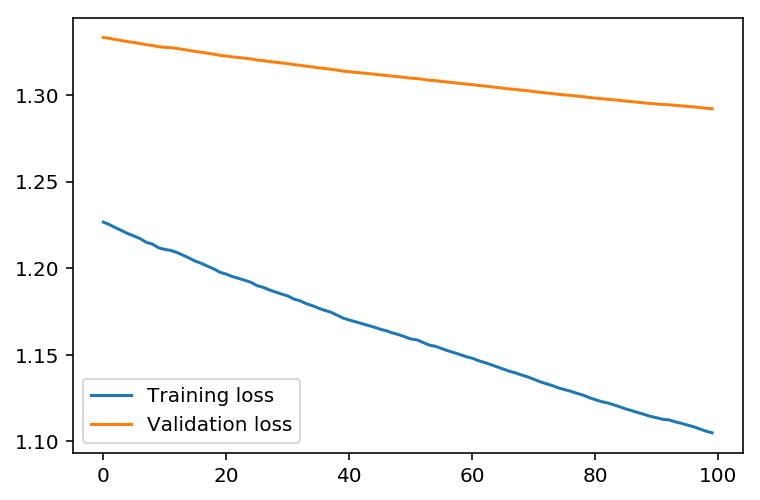

In [434]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

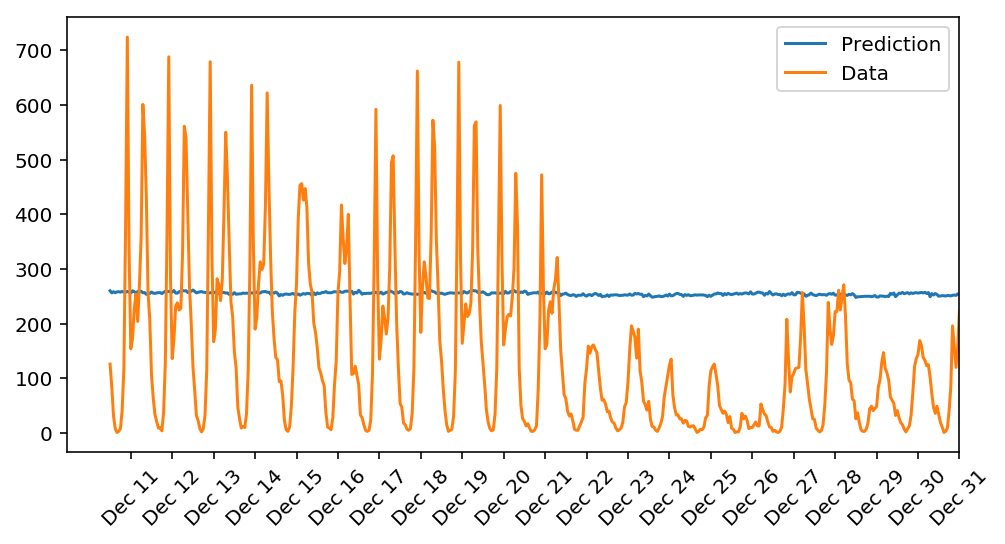

In [435]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below